In [1]:
import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd

import pandas as pd
from pandas.errors import SettingWithCopyWarning
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr


from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
from shapely import wkt

import datetime
from datetime import date
import traceback

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=SettingWithCopyWarning) 
# SettingWithCopyWarning


In [2]:
## Quick test if load fire is slowing things down. 

import time
import glob

In [3]:
def get_reg_shp(reg):
    """ return the shape of a region, given an optional reg input

    Parameters
    ----------
    reg : object
        region definition, one of the following
         - a geometry
         - a four-element list showing the extent of the region [lonmin,latmin,lonmax,latmax]
         - a country name

    Returns
    -------
    shp_Reg : geometry
        the geometry of the region shape
    """
    from shapely.geometry import Point, Polygon
    import shapely

    # read or form shape used for filtering active fires
    if isinstance(reg, shapely.geometry.base.BaseGeometry):
        shp_Reg = reg
    elif isinstance(reg, str):
        shp_Reg = get_Cty_shp(reg)
        if shp_Reg is None:
            print("Please input a valid Country name")
            return None
    elif isinstance(reg, list):
        shp_Reg = Polygon(
            [
                [reg[0], reg[1]],
                [reg[0], reg[3]],
                [reg[2], reg[3]],
                [reg[2], reg[1]],
                [reg[0], reg[1]],
            ]
        )
    else:
        print(
            "Please use geometry, country name (in str), or [lonmin,latmin,lonmax,latmax] list for the parameter region"
        )
        return None

    return shp_Reg

In [90]:
# start = time.time()

# # "/projects/shared-buckets/gsfc_landslides/
# lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS_REDO/2020/Largefire/F' + '9677' + '_*')
# fire = gpd.read_file( lf_files[-1],layer='nfplist')

# # Grab Currrent Time After Running the Code
# end = time.time()

# #Subtract Start Time from The End Time
# total_time = end - start
# print("\n"+ str(total_time))

In [5]:
#fire

In [6]:
# import time
# start = time.time()

# gdf = fv.load_large_fire('9677', year = "2020", path_region="WesternUS_REDO")

# # Grab Currrent Time After Running the Code
# end = time.time()

# #Subtract Start Time from The End Time
# total_time = end - start
# print("\n"+ str(total_time))

In [4]:
manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")
manyfr.columns
manyfr["func_failed"].unique()
debug = manyfr[(manyfr["func_failed"] == 'load_large_fire/get_gpm')  ]
manyfr = manyfr[(manyfr["func_failed"] != 'load_large_fire/get_gpm')  ]

/tmp/ipykernel_8738/3563504125.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,11,12,16,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")


In [5]:
len(manyfr.fireID.astype("str").unique()) + len(debug.fireID.unique())

574

In [46]:
#manyfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_PNW_2020_2023-03-07region_workflow_hourly.csv", parse_dates= True) #dtype={"fireID": str}
#debug = pd.read_csv("/projects/my-public-bucket/fire_spread/DEBUG_WesternUS_REDO_PNW_2020_2023-03-07region_workflow_hourly.csv")

In [6]:
manyfr.columns
manyfr.fireID

0          8752.0
1          8752.0
2          8752.0
3          8752.0
4          8752.0
           ...   
319894    17970.0
319895    17970.0
319896    17970.0
319897    17970.0
319898    17970.0
Name: fireID, Length: 319879, dtype: float64

In [5]:
#plt.scatter(manyfr[manyfr.fireID.astype("str") == "117"].t, manyfr[manyfr.fireID.astype("str") == "117"].farea)
manyfr = manyfr[manyfr.n_pixels.notna()]
manyfr = manyfr.sort_values(by = ["t"])

manyfr.geometry = manyfr.geometry.apply(wkt.loads)
manyfr = gpd.GeoDataFrame(manyfr, geometry = "geometry")

In [ ]:
### Static Source filtering
dirextdata = '/projects/shared-buckets/gsfc_landslides/FEDSinput/'
source = "VIIRS_Global_flaring_d.7_slope_0.029353_2017_web_v1.csv"


global_flaring = gpd.read_file(os.path.join(dirextdata,'static_sources', source))
global_flaring = global_flaring.drop_duplicates()
global_flaring = global_flaring[0:(len(global_flaring.id_key_2017) - 1)]

global_flaring = gpd.GeoDataFrame(global_flaring, geometry=gpd.points_from_xy(global_flaring.Longitude, global_flaring.Latitude))

global_flaring["buffer_geometry"] = global_flaring.buffer(0.2)

global_flaring = global_flaring.set_geometry(col = "buffer_geometry")
global_flaring.geometry

with_sources = len(manyfr.fireID.unique())
joinfr = gpd.sjoin(manyfr, global_flaring, how='left', op='within')
joinfr = joinfr[joinfr.geometry_right.isna()]

manyfr = manyfr[manyfr.fireID.isin(joinfr.fireID.unique())]

no_sources = len(manyfr.fireID.unique())

print("With souces, 2020 had ", with_sources, " fires over 5km ^2. Filtering removed to that we were left with ", no_sources) 

/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [26]:
#print(len(test_filter[test_filter.geometry_right.isna()]))

#print(len(manyfr))

25079
31195


In [9]:
### Correct ignition double counting? 
#manyfr["spread_line_ig"] = manyfr.spread_line  

manyfr

Unnamed: 0 n_pixels n_newpixels               farea  \
208614      208614      3.0         3.0            0.413636   
208615      208615      6.0         3.0            1.281363   
208616      208616     23.0        17.0             4.61519   
208617      208617     23.0         0.0             4.61519   
208618      208618     23.0         0.0             4.61519   
...            ...      ...         ...                 ...   
138556      138556    227.0         0.0           32.149973   
29800        29800    102.0         0.0           16.816863   
150338      150338       24           0   5.134330064786509   
158732      158732     44.0         0.0   6.409607088231584   
261683      261683    139.0         0.0  11.675226531942942   

                    fperim  flinelen duration              pixden   meanFRP  \
208614            2.478392  2.478392      0.0            7.252755  3.843333   
208615              7.0736  4.505661      0.0            4.682515  0.376667   
208616           15.227343  9.599365      0.5            4.983543  6.981596   
208617           15.227343       0.0      0.5            4.983543       0.0   
208618           15.227343       0.0      0.5            4.983543       0.0   
...                    ...       ...      ...                 ...       ...   
138556           23.368804       0.0      7.5            7.060659       0.0   
29800            23.424611       0.0     30.0             6.06534       0.0   
150338  14.041233925949024       0.0      0.5   4.674417050941571       0.0   
158732   18.57471347622765       0.0      1.5   6.864695354070391       0.0   
261683  23.941387629234207       0.0     28.5  11.905550579228736       0.0   

                          t  ... spread_periodNight_lag_-4  \
208614  2020-01-02 12:00:00  ...                     False   
208615  2020-01-03 00:00:00  ...                     False   
208616  2020-01-03 12:00:00  ...                      True   
208617  2020-01-04 00:00:00  ...                      True   
208618  2020-01-04 12:00:00  ...                     False   
...                     ...  ...                       ...   
138556  2020-12-31 12:00:00  ...                       NaN   
29800   2020-12-31 12:00:00  ...                       NaN   
150338  2020-12-31 12:00:00  ...                       NaN   
158732  2020-12-31 12:00:00  ...                       NaN   
261683  2020-12-31 12:00:00  ...                       NaN   

       spread_periodNight_lag_-12 spread_periodNight_lag_-24  \
208614                      False                      False   
208615                      False                      False   
208616                      False                      False   
208617                      False                      False   
208618                      False                      False   
...                           ...                        ...   
138556                       True                        NaN   
29800                         NaN                      False   
150338                        NaN                        NaN   
158732                      False                        NaN   
261683                        NaN                       True   

        spread_periodNight_lag_-48 spread_periodDay spread_periodDay_lag_-2  \
208614                       False              NaN                    True   
208615                       False             True                   False   
208616                         NaN             True                   False   
208617                         NaN            False                   False   
208618                         NaN            False                   False   
...                            ...              ...                     ...   
138556                         NaN            False                    True   
29800                        False            False                     NaN   
150338                         NaN            False                     NaN  

In [20]:
#at_t.farea

In [6]:
### Look at % spread on specifc days

def percent_spread_time(manyfr):
    
    time = manyfr.t.unique()

    time_sum = []
    for i in time: 
        #print(i)
        try:
            at_t = manyfr[manyfr.t == i]
            at_t_spread = at_t[(at_t.spread_line.astype("str") == 'True') | (at_t.spread_line.astype("str") == '1')]
            at_t_ig = at_t[at_t.spread_line.astype("str") == "2"]
            at_t_not_spread = at_t[(at_t.spread_line.astype("str") == 'False') | (at_t.spread_line.astype("str") == '0')]
        except:
            print("Skipping ", i)
            next
        else:
            num_fires = len(at_t.fireID)
            num_spread = len(at_t_spread.fireID)
            num_ig = len(at_t_ig.fireID)

            num_percent_spread = num_spread/num_fires
            num_percent_spread_ig = (num_spread + num_ig)/num_fires
            num_percent_ig = num_ig/num_fires

            fire_labs_all = str(at_t.fireID)
            fire_labs_spread = str(at_t_spread.fireID)
            fire_labs_ig = str(at_t_ig.fireID)

            area = sum(at_t.farea.astype("float").dropna())
            area_spread = sum(at_t_spread.farea.astype("float").dropna())

            delta_area = sum(at_t.farea_diff.astype("float").dropna())
            #print(at_t)
            delta_area_spread = sum(at_t_spread.farea_diff.astype("float").dropna().values)
            #print(delta_area_spread)
            delta_area_ig = sum(at_t_ig.farea.astype("float").dropna()) ## Repeats from dat to night

            area_percent_spread = area_spread/area
            area_percent_spread_ig = (area_spread + delta_area_ig)/area
            area_percent_ig = (delta_area_ig)/area

            delta_area_percent_spread = delta_area_spread/area
            delta_area_percent_spread_ig = (delta_area_spread + delta_area_ig)/area

            mean_spread_fwi = np.mean(at_t_spread['GEOS-5_FWI'].astype("float").dropna())
            mean_not_spread_fwi = np.mean(at_t_not_spread['GEOS-5_FWI'].astype("float").dropna())
            max_spread_fwi = np.max(at_t_spread['GEOS-5_FWI'].astype("float").dropna())

            time_sum.append([i, num_fires,num_spread, num_ig, 
                             num_percent_spread,num_percent_spread_ig,num_percent_ig, 
                             fire_labs_all, fire_labs_spread, fire_labs_ig, 
                             area, area_spread,
                             delta_area, delta_area_spread, delta_area_ig,
                             area_percent_spread, area_percent_spread_ig, area_percent_ig, 
                             delta_area_percent_spread, delta_area_percent_spread_ig, 
                             mean_spread_fwi, mean_not_spread_fwi, max_spread_fwi])
            
    timeline = pd.DataFrame(data = time_sum, columns = ["t",'num_fires','num_spread', 'num_ig', 
                                                        'num_percent_spread', 'num_percent_spread_ig', 'num_percent_ig', 
                                                        'fire_labs_all', 'fire_labs_spread', 'fire_labs_ig', 
                                                        'area', 'area_spread', 
                                                        'delta_area', 'delta_area_spread', 'delta_area_ig',
                                                        'area_percent_spread', 'area_percent_spread_ig', 'area_percent_ig',
                                                        'delta_area_percent_spread', 'delta_area_percent_spread_ig',
                                                        "mean_spread_fwi", "mean_not_spread_fwi", "max_spread_fwi"])
    return(timeline)


In [129]:
i

(19, 20)

In [7]:
### For loop of percent spread
## find all fireids in snapshot
pnw = gpd.read_file("/projects/my-public-bucket/fire_weather_vis/ref_data/NEON_DOMAIN/NEON_Domains.shp")# quickly subset by state to avoid computational stuff
#pnw = pnw[pnw.DomainID == 16]
pnw.set_crs('EPSG:4326')
manyfr.set_crs('EPSG:4326')
#join = gpd.tools.sjoin(manyfr,pnw, predicate="within")
#ids = join.fireID.unique()

pnw = pnw.set_crs('EPSG:4326')

pnw["x"] = pnw.centroid.x
pnw["y"] = pnw.centroid.y
pnw.DomainName.astype("str")



/tmp/ipykernel_8738/937050815.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pnw["x"] = pnw.centroid.x
/tmp/ipykernel_8738/937050815.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pnw["y"] = pnw.centroid.y


0                               Northeast
1                               Northeast
2                            Mid Atlantic
3                               Southeast
4                    Atlantic Neotropical
5                    Atlantic Neotropical
6                             Great Lakes
7                       Prairie Peninsula
8       Appalachians / Cumberland Plateau
9                          Ozarks Complex
10                        Northern Plains
11                         Central Plains
12                        Southern Plains
13                       Northern Rockies
14    Southern Rockies / Colorado Plateau
15                       Desert Southwest
16                            Great Basin
17                      Pacific Northwest
18                      Pacific Southwest
19                                 Tundra
20                                  Taiga
21                       Pacific Tropical
Name: DomainName, dtype: object

In [8]:
region = ('WesternUS',[-125.698046875,31.676476158707615,
                           -101.00078125,49.51429477264348])
reg = get_reg_shp(region[1])

foo = {"geometry":[str(reg)], 
      "name":["WesternUS"] }
foo_df = pd.DataFrame.from_dict(foo)

from shapely import wkt

foo_df.geometry = foo_df.geometry.apply(wkt.loads)
reg = gpd.GeoDataFrame(foo_df, geometry = "geometry")
reg = reg.set_crs('EPSG:4326')

used_neon_regions = gpd.tools.sjoin(pnw, reg, predicate="within")
used_neon_regions.DomainName.unique()

array(['Northern Rockies', 'Southern Rockies / Colorado Plateau',
       'Great Basin', 'Pacific Southwest'], dtype=object)

In [13]:
pnw

OBJECTID  Shape_Leng  DomainID                           DomainName  \
0         69   53.680391         1                            Northeast   
1          0    0.000000         1                            Northeast   
2         71   71.837021         2                         Mid Atlantic   
3         74   89.155850         3                            Southeast   
4         75    7.095503         4                 Atlantic Neotropical   
5          0    0.000000         4                 Atlantic Neotropical   
6         70   53.326730         5                          Great Lakes   
7         64   57.000158         6                    Prairie Peninsula   
8         72   34.120941         7    Appalachians / Cumberland Plateau   
9         73   46.997736         8                       Ozarks Complex   
10        76   62.375832         9                      Northern Plains   
11        77   35.883454        10                       Central Plains   
12        68   44.360574        11                      Southern Plains   
13        63   29.365576        12                     Northern Rockies   
14        67   45.131924        13  Southern Rockies / Colorado Plateau   
15        66   56.098533        14                     Desert Southwest   
16       152   64.074378        15                          Great Basin   
17        87  204.654121        16                    Pacific Northwest   
18        65   34.864789        17                    Pacific Southwest   
19        79  198.725448        18                               Tundra   
20       196  141.865684        19                                Taiga   
21        50   11.956685        20                     Pacific Tropical   

    Shape_Le_1  Shape_Area                                           geometry  \
0    53.680391   47.569872  POLYGON ((-74.27834 40.49807, -74.28257 40.500...   
1     5.402444    0.390299  POLYGON ((-72.52494 40.98139, -72.59348 40.912...   
2    71.837021   35.426442  POLYGON ((-74.27237 40.47629, -74.27095 40.474...   
3    89.155850   37.912866  POLYGON ((-97.02705 28.11202, -97.02696 28.111...   
4     7.095503    2.423254  POLYGON ((-81.84061 26.32044, -81.75934 26.348...   
5     4.772671    0.749463  POLYGON ((-67.05686 18.51136, -66.94605 18.488...   
6    53.326730   62.083895  POLYGON ((-94.18927 45.50598, -94.38144 45.515...   
7    57.000158   69.868670  POLYGON ((-98.28292 37.26871, -98.27969 37.403...   
8    34.120941   31.246548  POLYGON ((-81.49878 40.57205, -81.36265 40.411...   
9    46.997736   67.148057  POLYGON ((-89.11197 37.25877, -88.94376 37.241...   
10   62.375832  100.394404  POLYGON ((-96.90798 41.56133, -99.78301 41.607...   
11   35.883454   46.483168  POLYGON ((-100.50555 41.60172, -96.90798 41.56...   
12   44.360574   51.180289  POLYGON ((-98.07153 26.03841, -98.07359 26.036...   
13   29.365576   37.730214  POLYGON ((-113.19998 49.00035, -113.19543 48.9...   
14   45.131924   65.099979  POLYGON ((-104.51072 33.93427, -104.67244 33.9...   
15   56.098533   42.245950  POLYGON ((-115.18698 36.71963, -115.15906 36.5...   
16   64.074378   92.115319  POLYGON ((-121.95684 43.06169, -121.95353 43.0...   
17  204.654121   47.721775  MULTIPOLYGON (((-151.97404 59.27044, -151.9393...   
18   34.864789   24.479970  POLYGON ((-118.19814 37.05539, -117.96085 37.0...   
19  198.725448  114.824539  MULTIPOLYGON (((-158.55446 57.12444, -158.2873...   
20  141.865684  132.147315  MULTIPOLYGON (((-163.36225 54.81105, -163.3878...   
21   11.956685    1.429011  MULTIPOLYGON (((-159.33797 21.95150, -159.4423...   

             x          y  
0   -74.556965  42.794573  
1   -73.109189  40.824868  
2   -78.971925  36.632454  
3   -86.139559  30.629654  
4   -80.794928  26.234123  
5   -66.478057  18.224763  
6   -87.617757  44.845016  
7   -92.296276  41.107184  
8   -84.034276  37.580517  
9   -90.995203  34.678569  
10 -102.686835  45.794705  
11 -101.682929  37.926617  
12  -98.473368  31.904497  
13 -113.298406  45.656

In [63]:
#joinfr = gpd.tools.sjoin(manyfr,pnw, predicate="within")
#joinfr.columns
timeline.columns

Index(['t', 'num_fires', 'num_spread', 'num_ig', 'num_percent_spread',
       'num_percent_spread_ig', 'num_percent_ig', 'fire_labs_all',
       'fire_labs_spread', 'fire_labs_ig', 'area', 'area_spread', 'delta_area',
       'delta_area_spread', 'delta_area_ig', 'area_percent_spread',
       'area_percent_spread_ig', 'area_percent_ig',
       'delta_area_percent_spread', 'delta_area_percent_spread_ig',
       'mean_spread_fwi', 'mean_not_spread_fwi', 'max_spread_fwi'],
      dtype='object')

In [9]:
#domain_ids = pnw.DomainID.unique()
#domain_names = pnw.DomainName.unicolumns()
#pnw.columns


import matplotlib.colors as colors

color_dict = {'Nighttime Ignition':'blue', 'Daytime Ignition':'orange'}

/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CR

['Northeast']:nan
['Mid Atlantic']:nan
['Southeast']:nan
['Atlantic Neotropical']:nan


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CR

['Great Lakes']:nan
['Prairie Peninsula']:nan
['Appalachians / Cumberland Plateau']:nan
['Ozarks Complex']:nan


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Northern Plains']:18


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Central Plains']:2


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Southern Plains']:4


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Northern Rockies']:22


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Southern Rockies / Colorado Plateau']:16


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Desert Southwest']:18


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Great Basin']:28


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Pacific Northwest']:18


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


['Pacific Southwest']:29
['Tundra']:nan
['Taiga']:nan
['Pacific Tropical']:nan


/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")
/tmp/ipykernel_8738/3203063999.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  join = gpd.tools.sjoin(manyfr,domain, predicate="within")


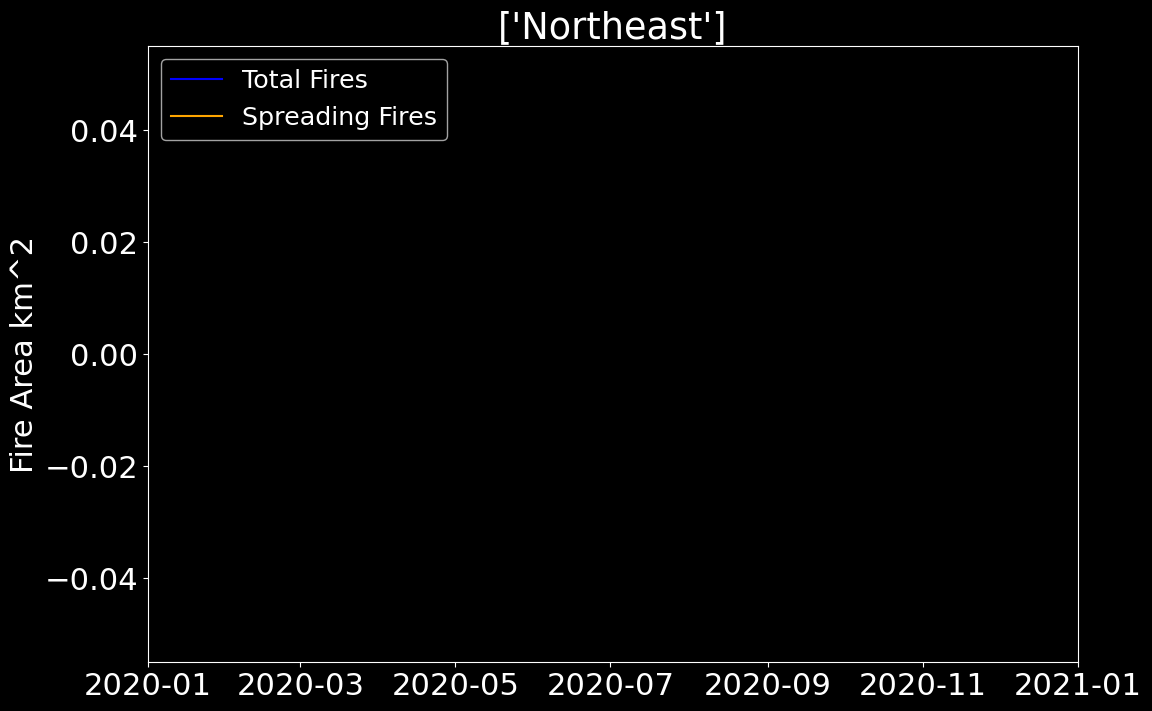

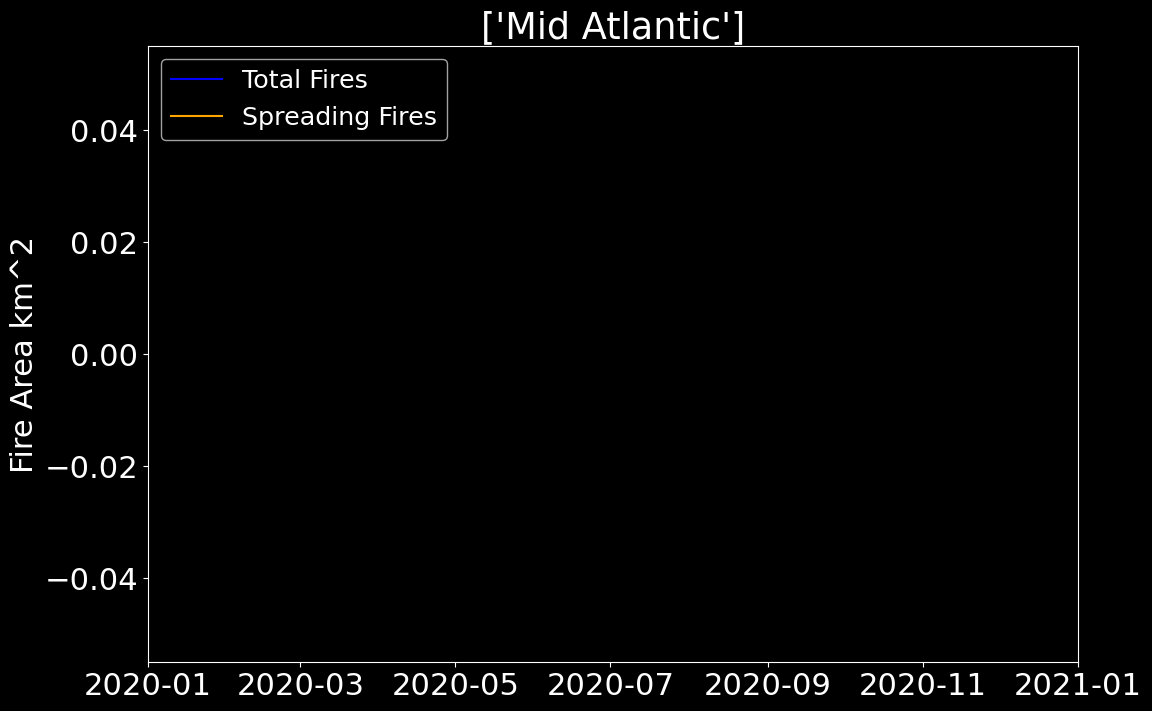

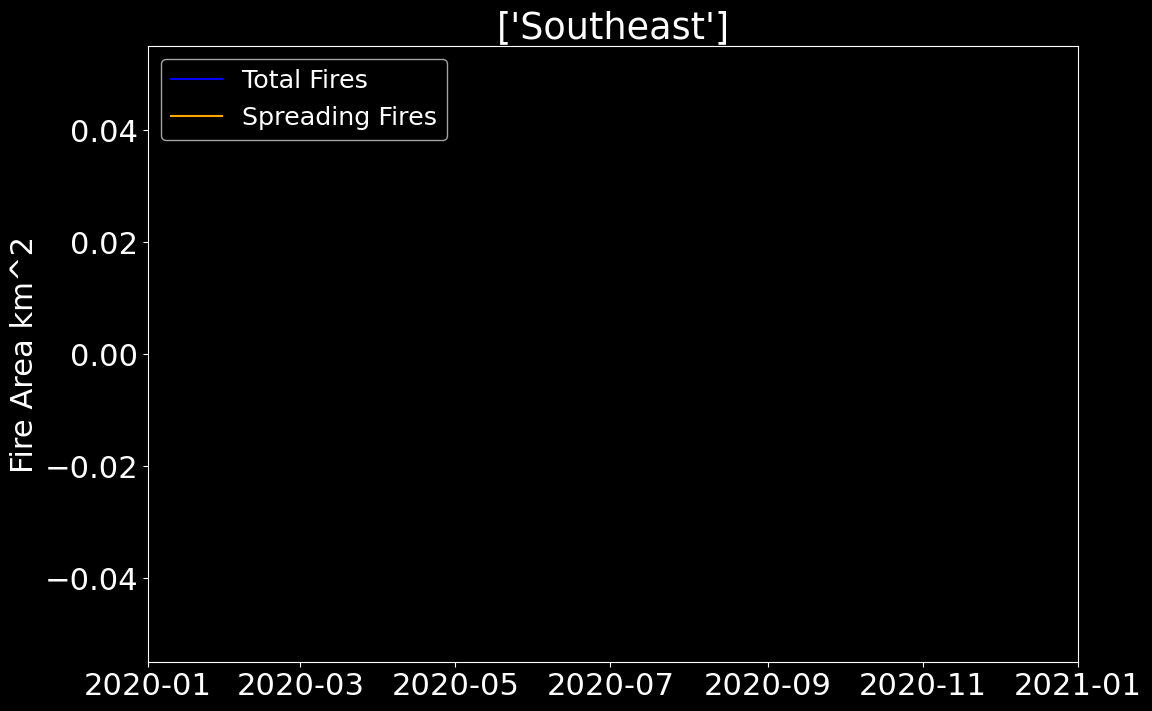

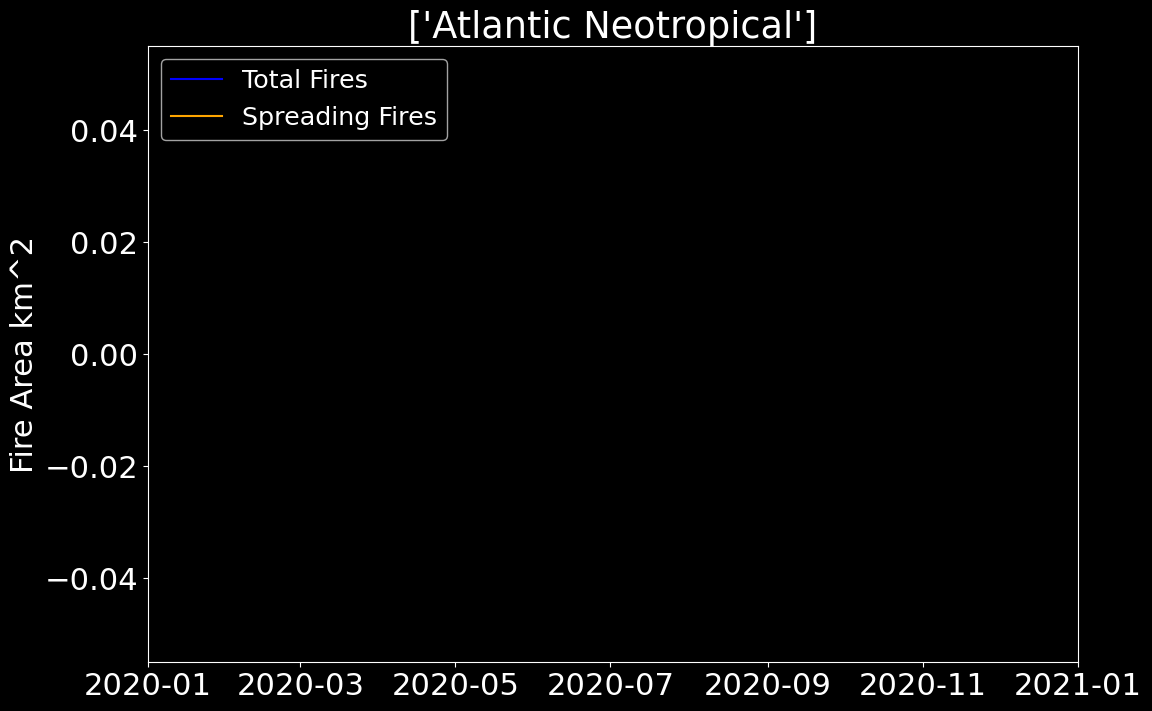

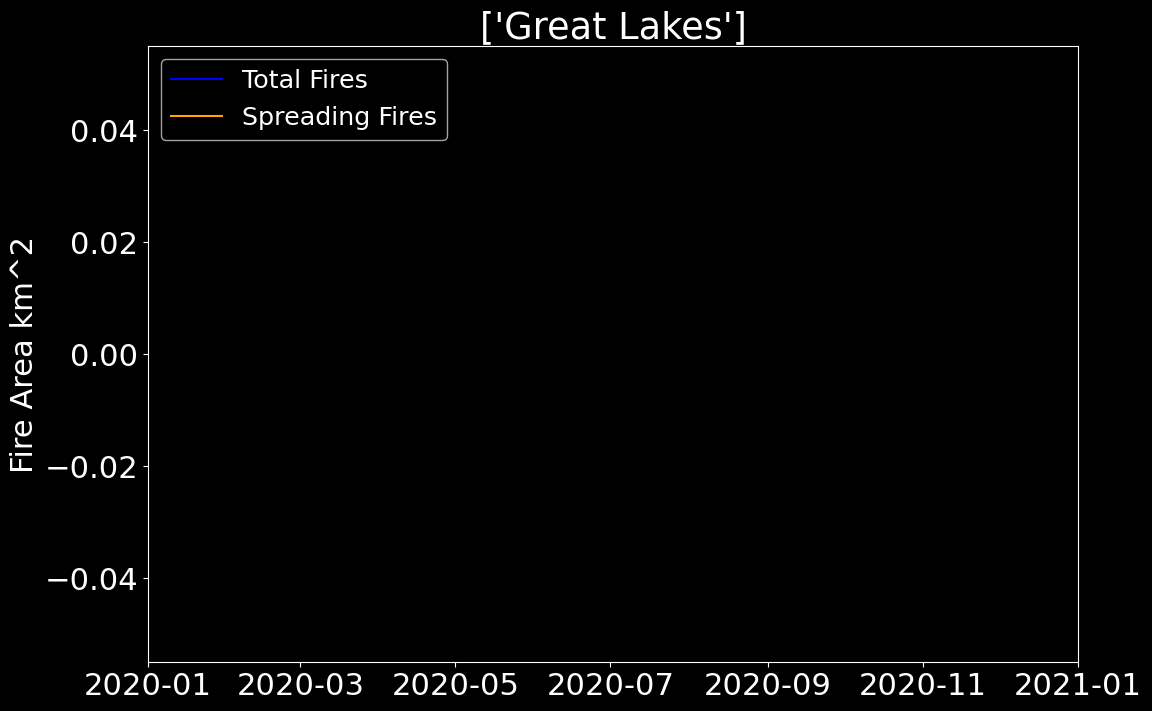

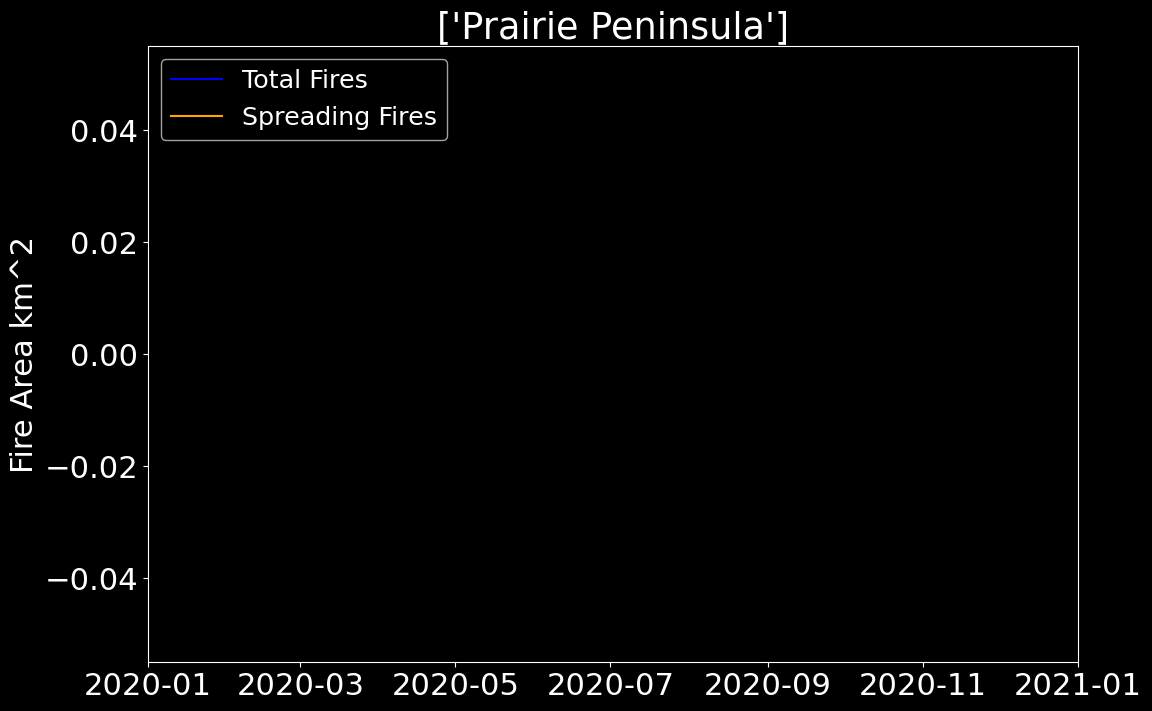

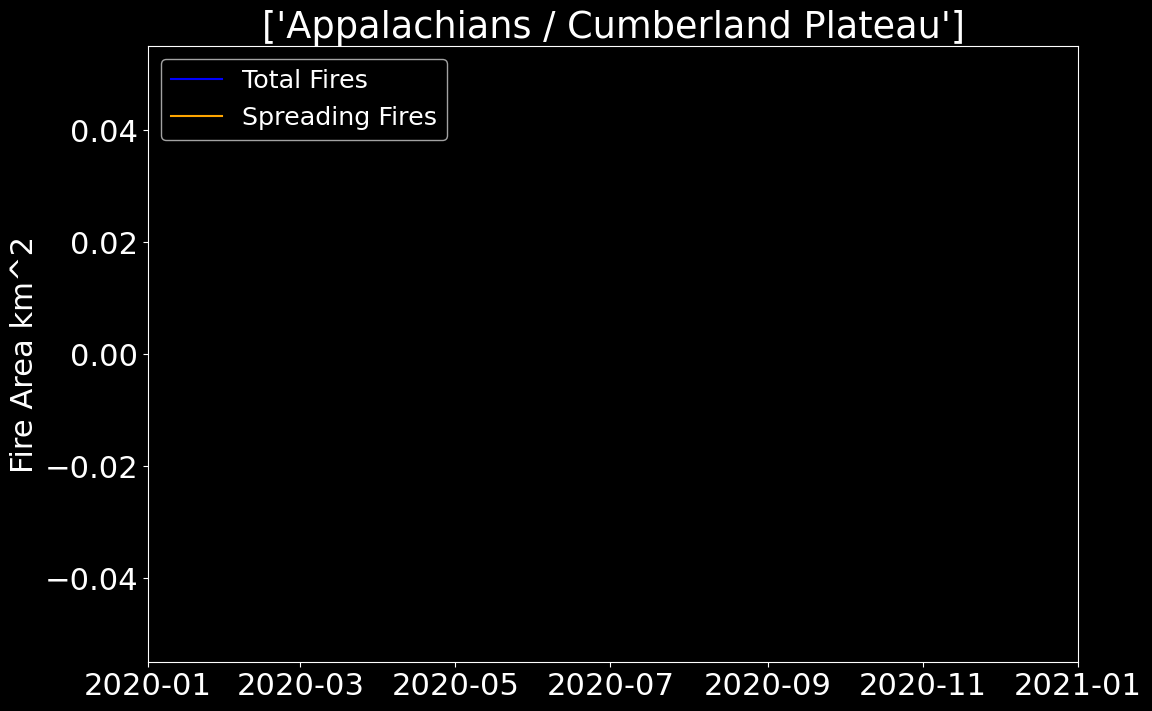

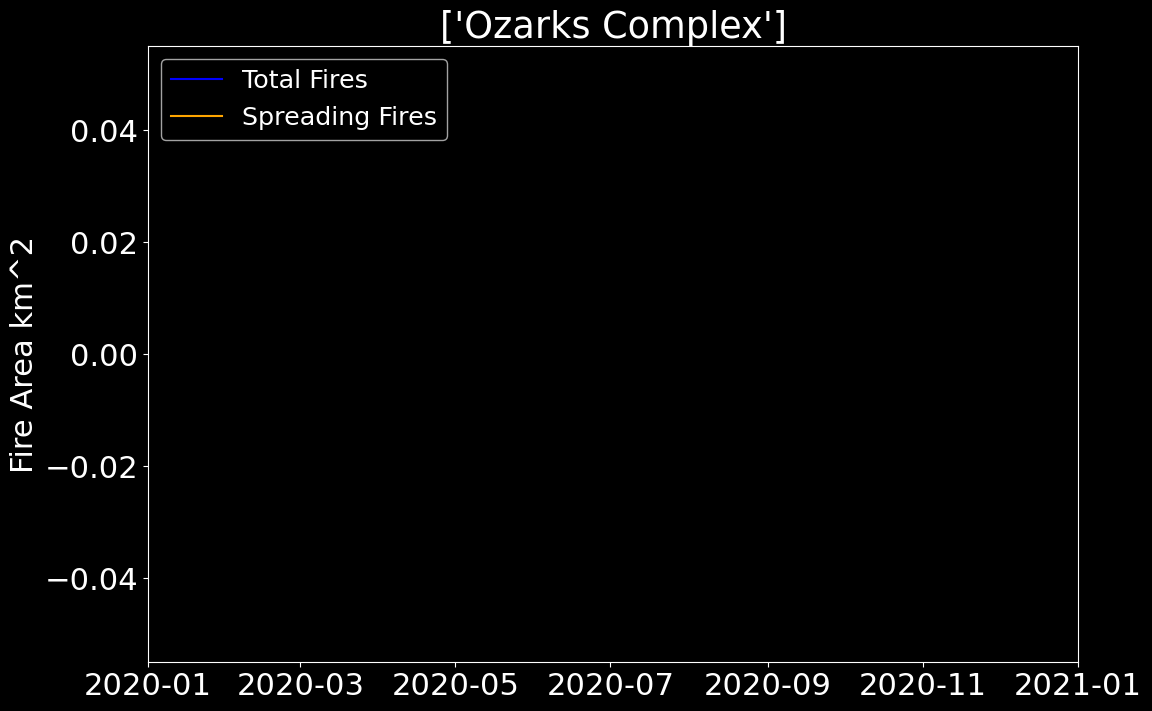

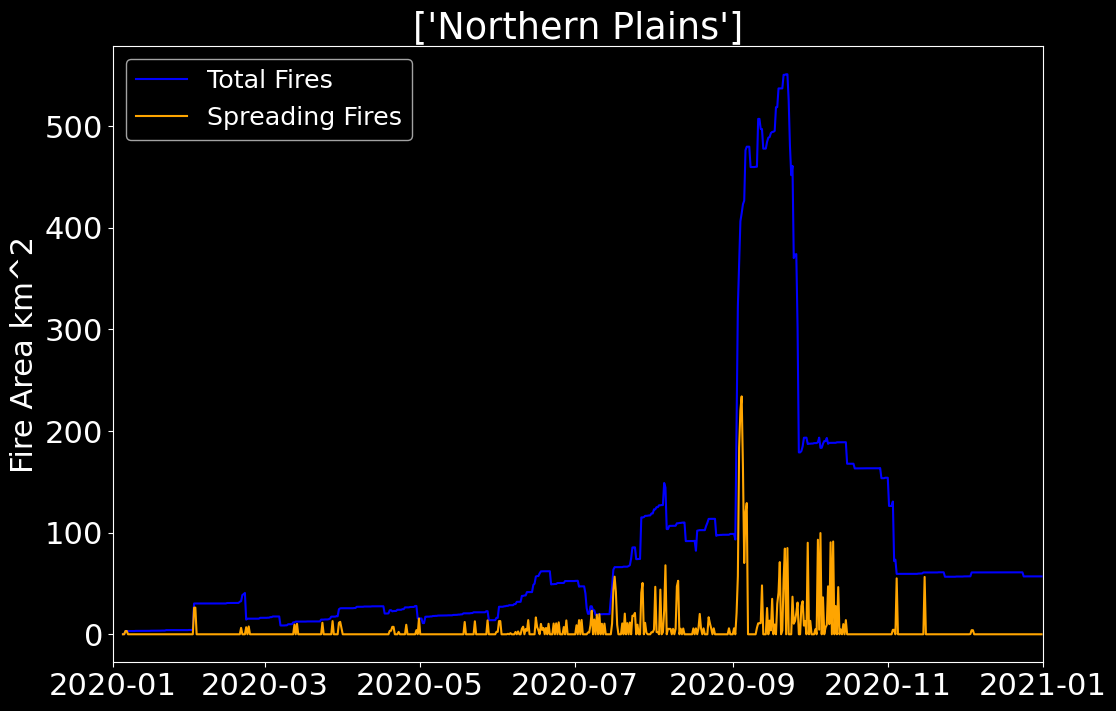

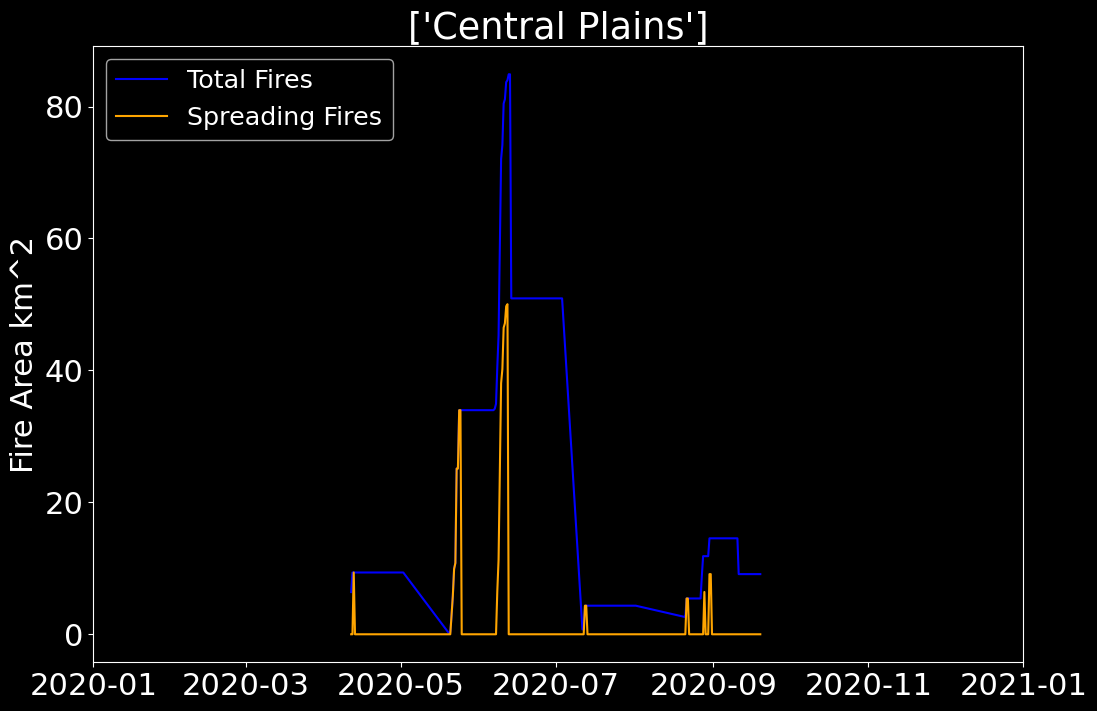

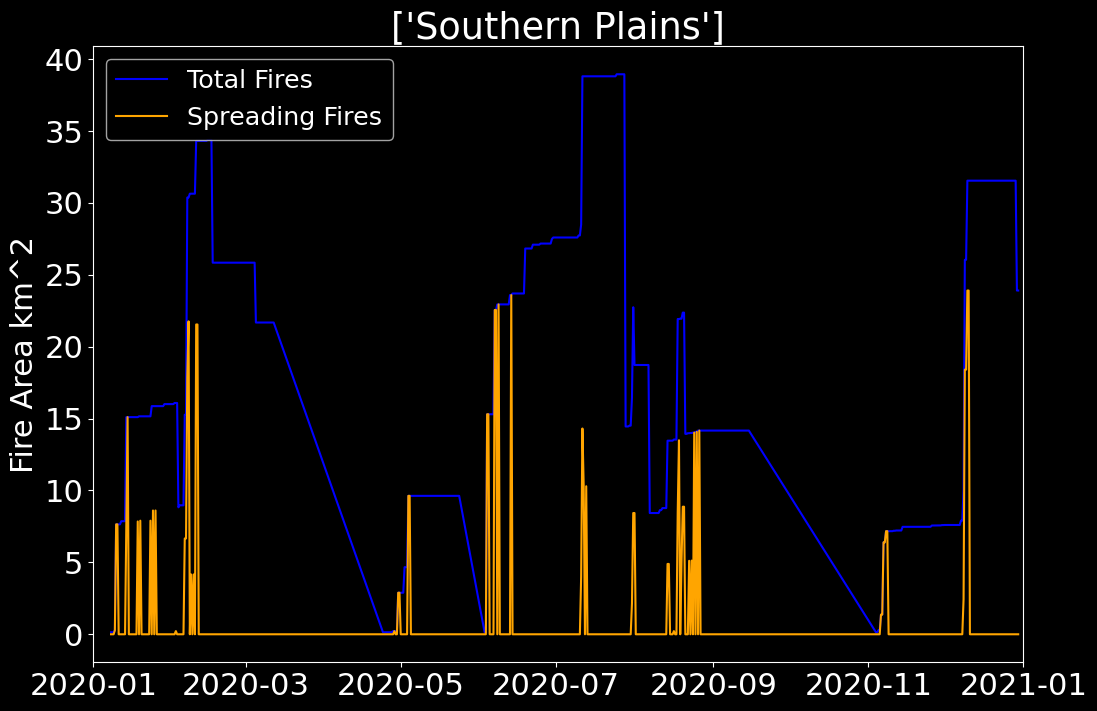

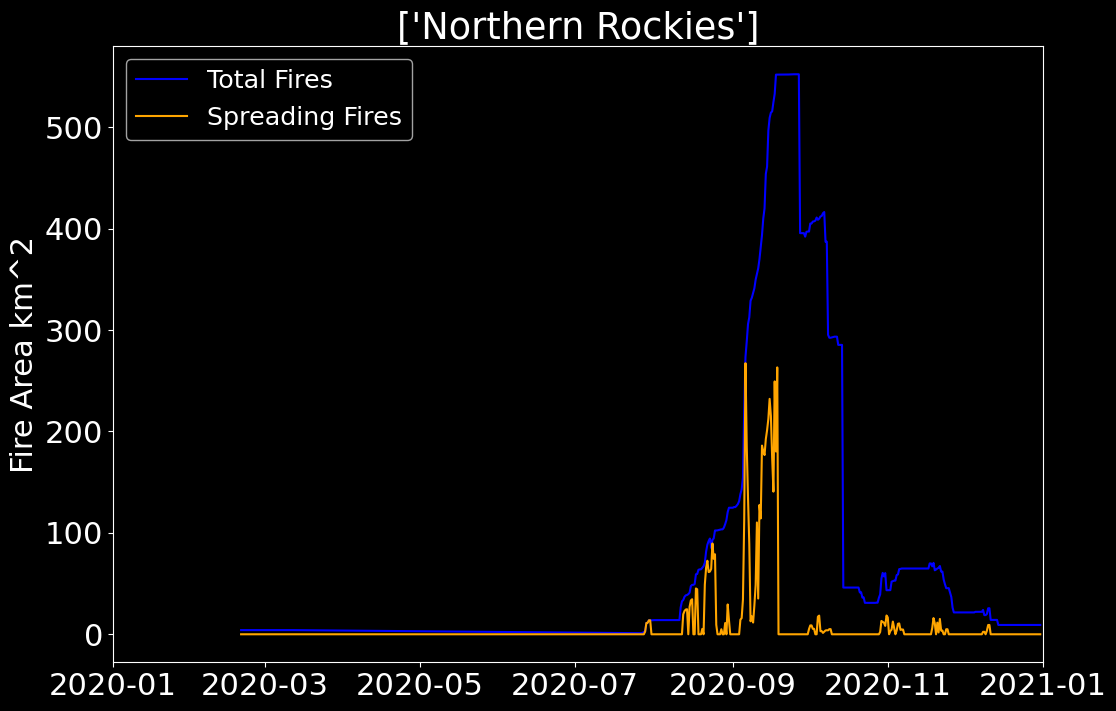

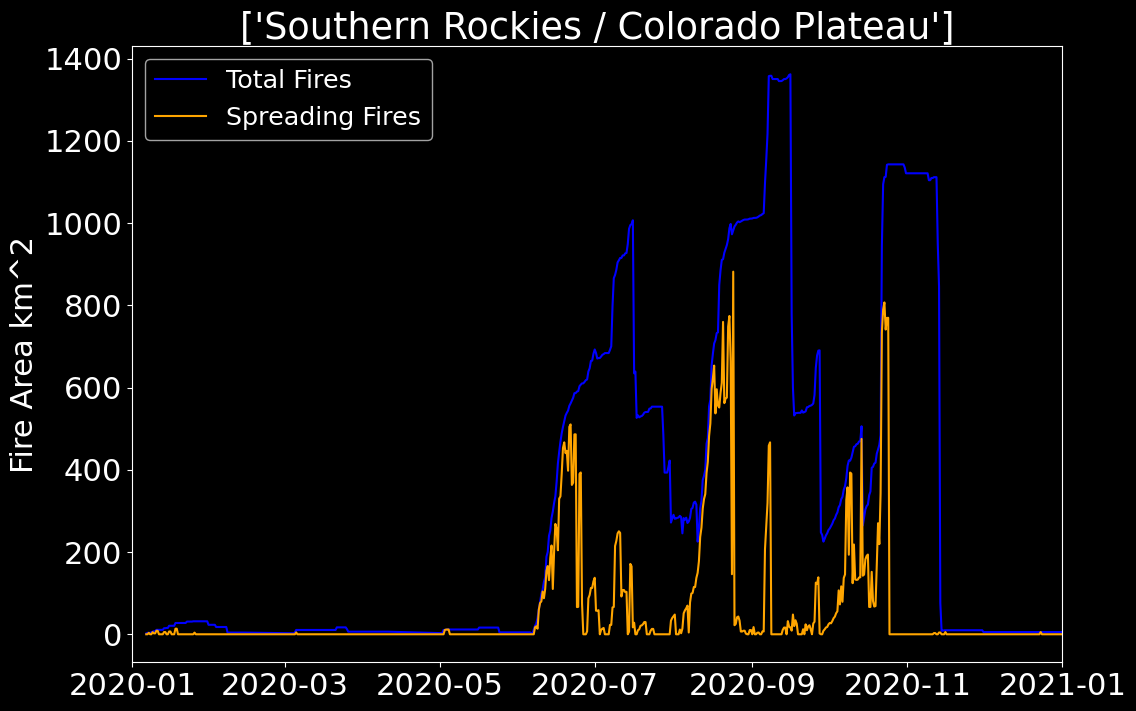

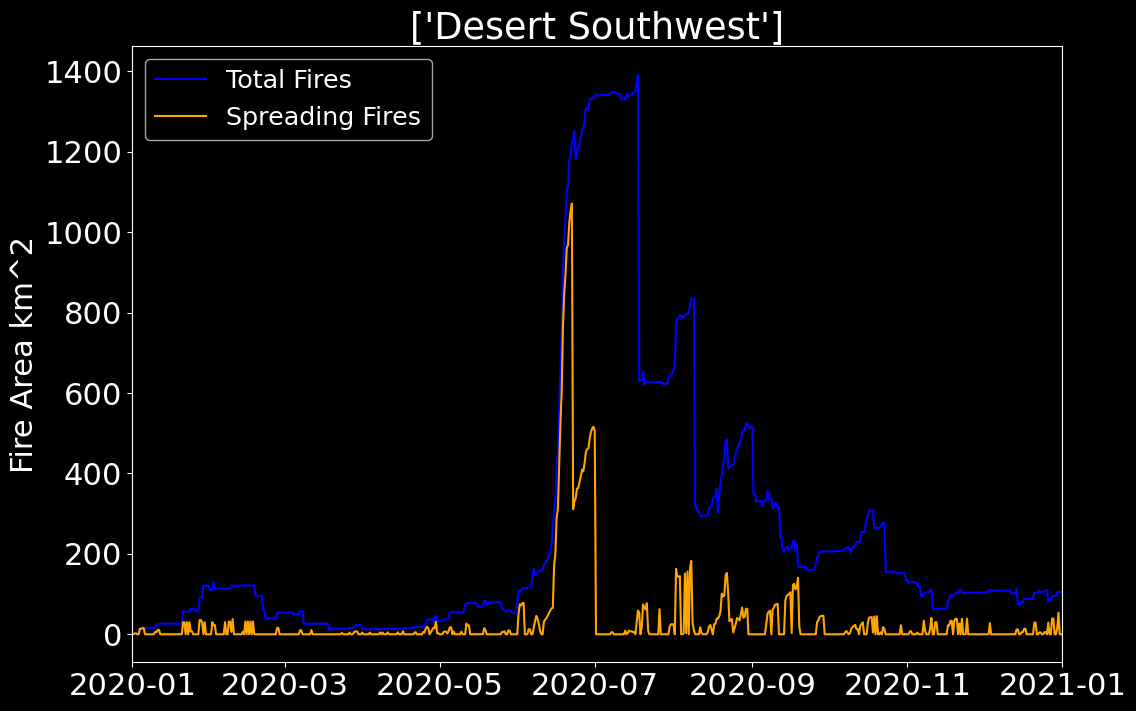

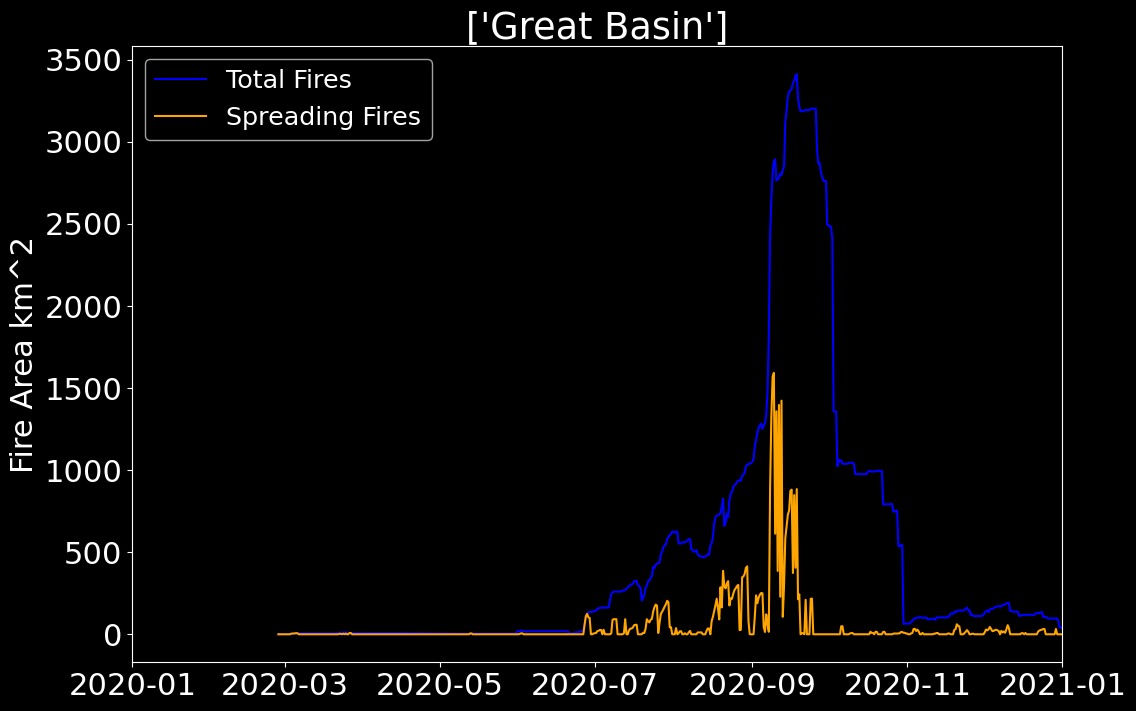

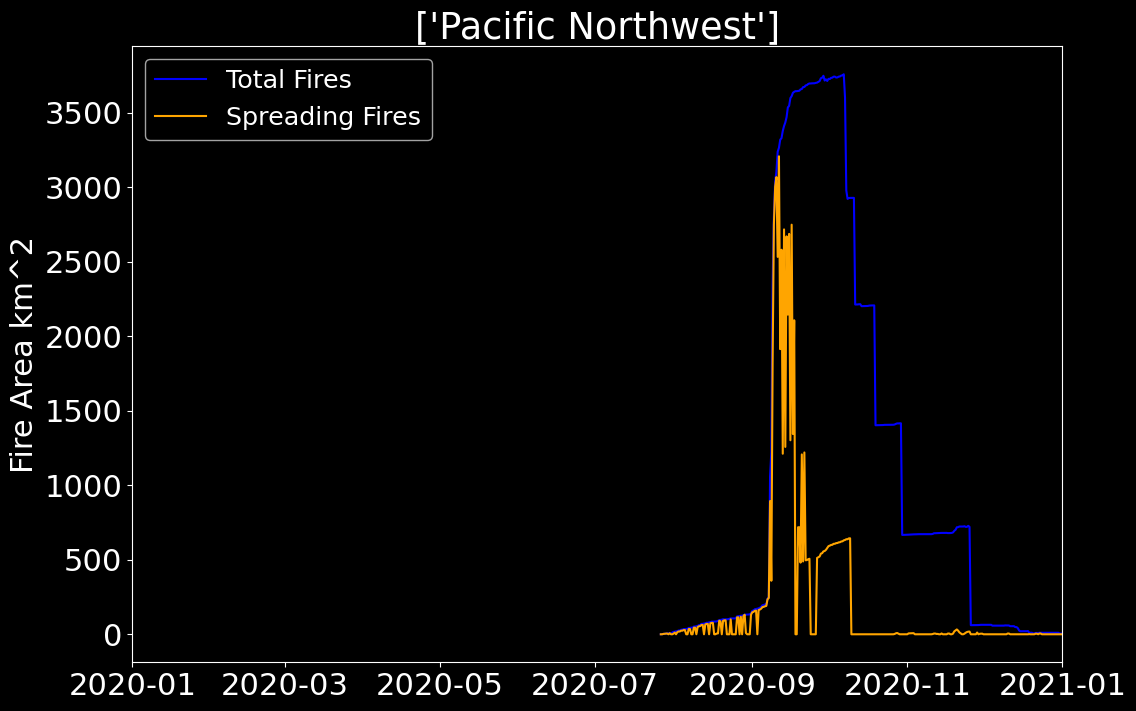

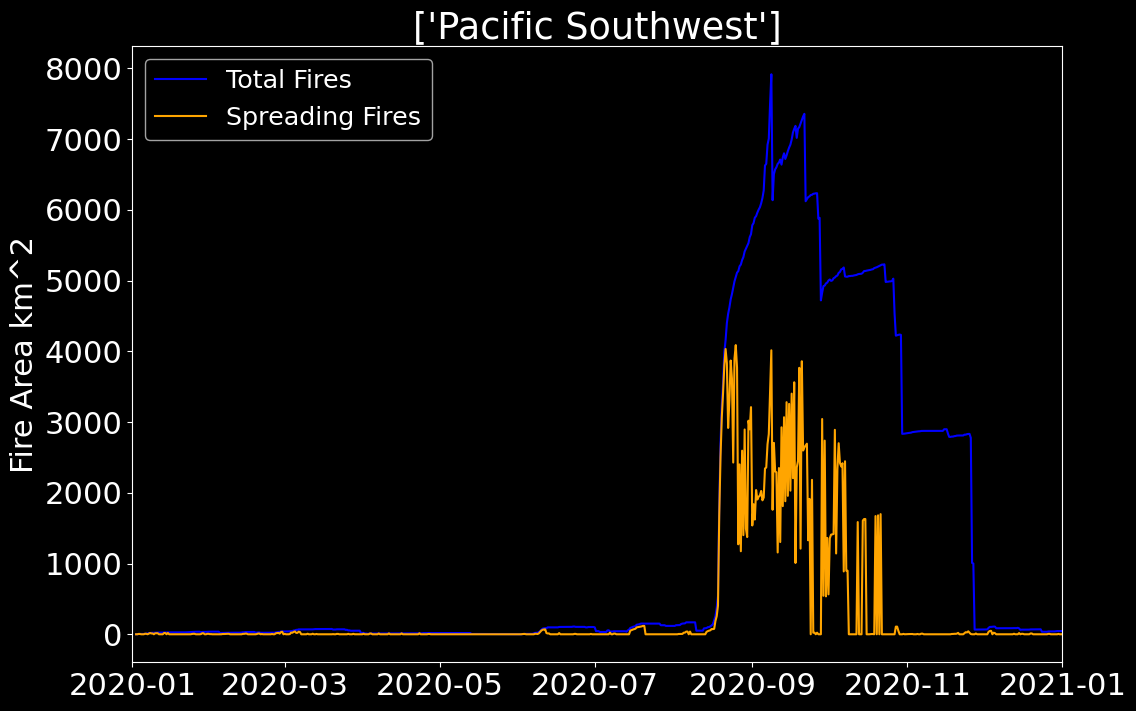

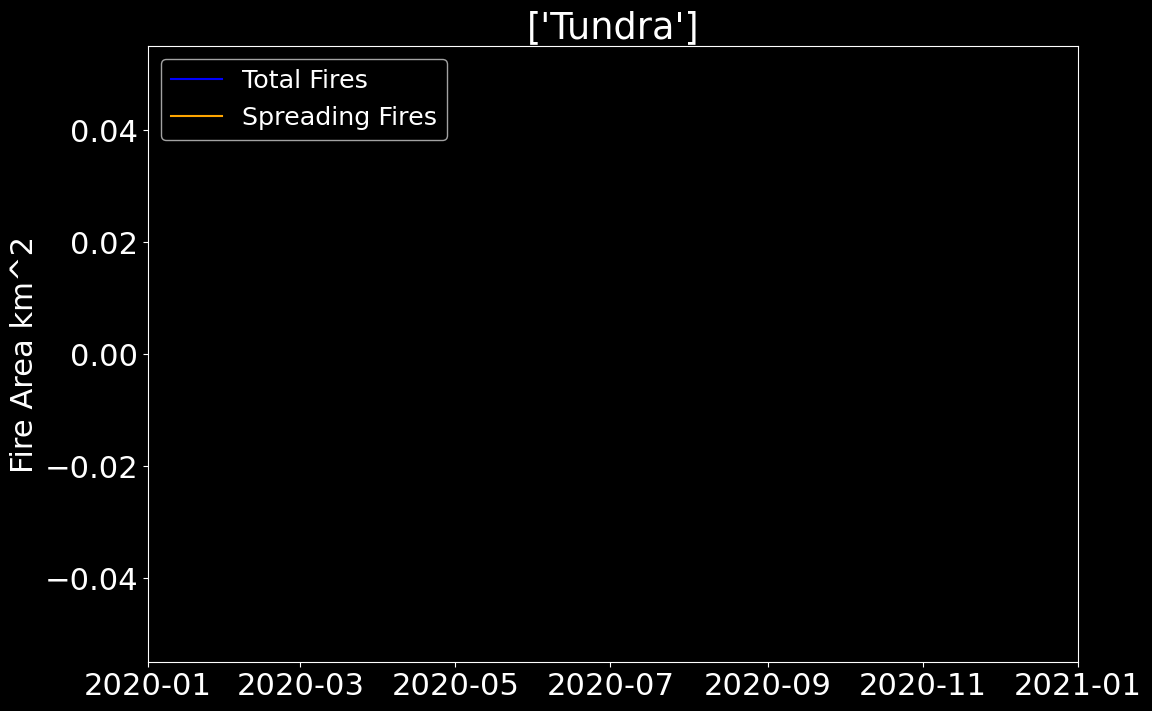

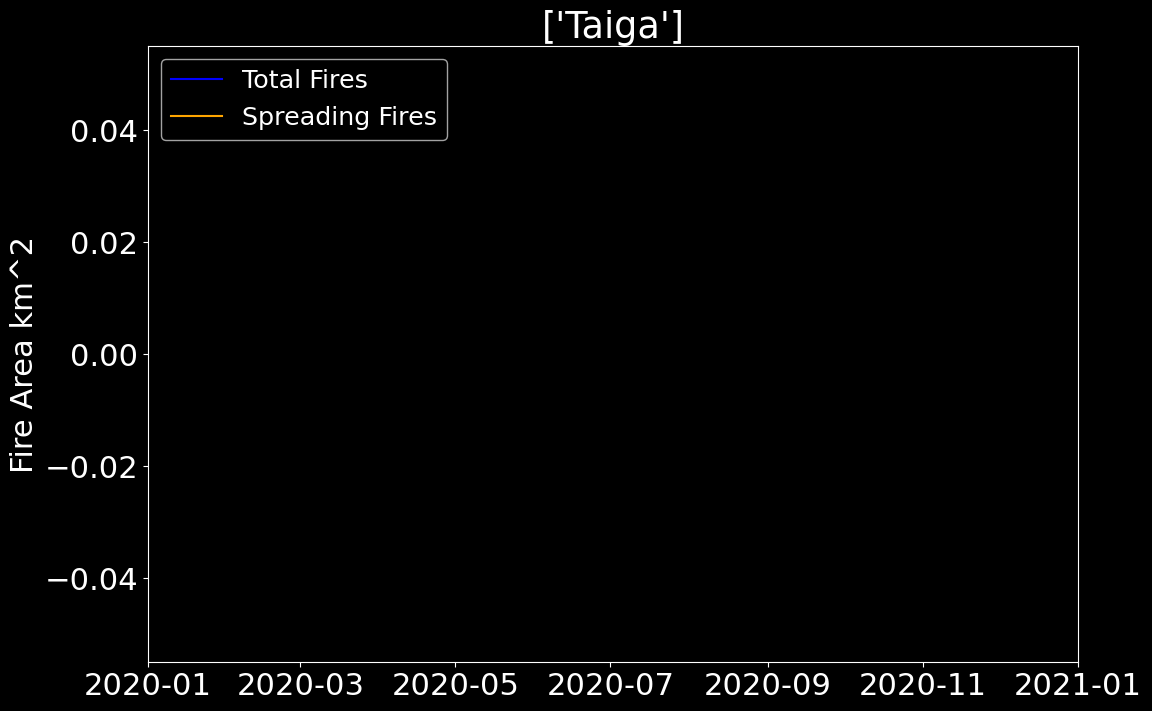

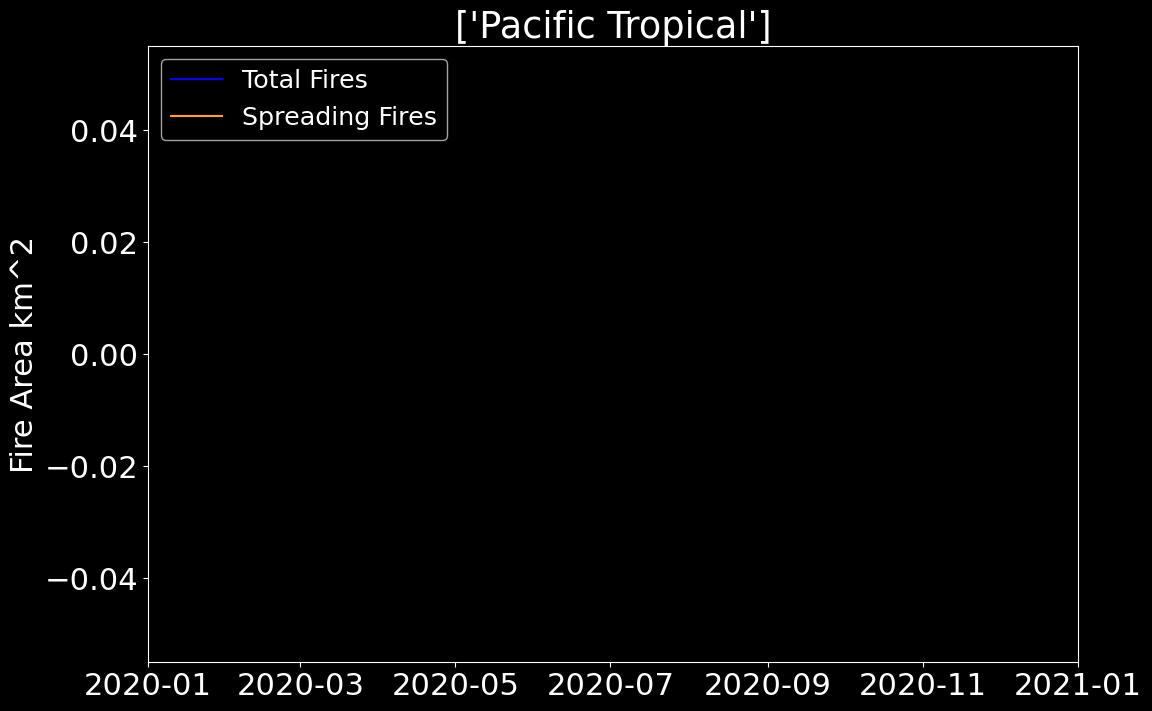

In [24]:
for i in pnw.DomainName.unique():
    #print(i)
    domain = pnw[pnw.DomainName.astype("str") == str(i)]
    #print(domain)
    domain.set_crs('EPSG:4326')
    join = gpd.tools.sjoin(manyfr,domain, predicate="within")
    timeline = percent_spread_time(join)
    timeline = timeline.sort_values(by = "t")

    
#     plt.plot(timeline.t.astype("datetime64[ns]"), timeline.num_fires) # blue
#     plt.plot(timeline.t.astype("datetime64[ns]"), timeline.num_spread) # Oragne
#     plt.plot(timeline.t.astype("datetime64[ns]"), timeline.num_ig) # green
#     plt.xticks(rotation=90)
#     plt.title(domain.DomainName.unique())
#     plt.show()
    
#     print(timeline.area)
#     plt.plot(timeline.t.astype("datetime64[ns]"), timeline.area) # blue
#     plt.plot(timeline.t.astype("datetime64[ns]"), timeline.area_spread) # Oragne
#     #plt.plot(timeline.t.astype("datetime64[ns]"), timeline.num_ig) # green
#     plt.xticks(rotation=90)
#     plt.title(domain.DomainName.unique())
#     plt.show()

#     fig, ax = plt.subplots(figsize=(12,8))
#     ax.plot(timeline.t.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
#     ax.plot(timeline.t.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
#     ax.plot(timeline.t.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
#     legend = ax.legend(loc='upper right', fontsize='small')
#     ax.set_ylabel("Number of fires", color = "Black")
#     ax2=ax.twinx()
#     #ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
#     #ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
#     ax2.scatter(timeline.t.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")

#     ax2.set_ylabel("Max FWI",color="purple")
#     plt.title(domain.DomainName.unique())
    

    fig, ax = plt.subplots(figsize=(12,8))
    plt.style.use('dark_background')
    plt.rcParams.update({'font.size': 22})
    ax.set_xlim([datetime.date(2020, 1, 1), datetime.date(2021, 1, 1)])
    print(str(domain.DomainName.unique()) + ":" + str(timeline.num_fires.max()))
    ax.plot(timeline.t.astype("datetime64[ns]"), timeline.area, label = "Total Fires", color = "blue")
    ax.plot(timeline.t.astype("datetime64[ns]"), timeline.area_spread, label = "Spreading Fires", color = 'orange')
    #ax.plot(timeline.t.astype("datetime64[ns]"), timeline.delta_area_ig, label = "Igniting Fires")

    legend = ax.legend(loc='upper left', fontsize='small')
    ax.set_ylabel("Fire Area km^2")
    #ax2=ax.twinx()
    #ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
    #ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
    
    #ax2.scatter(timeline.t.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")

    #ax2.set_ylabel("Max FWI",color="purple")
    plt.title(str(domain.DomainName.unique()))



#     if (len(timeline.index) != 0):
#         corr = np.correlate(a = timeline.num_fires.dropna(), v = timeline.max_spread_fwi.dropna(), mode = "full")
#         lag = corr.argmax() - (len(timeline.num_fires.dropna()) - 1)
#         print("lag:", lag)
#         plt.plot(corr)
#         plt.show()

#     plt.plot(timeline.t, timeline.num_fires) # blue
#     plt.plot(timeline.t, timeline.num_spread) # Oragne
#     plt.plot(timeline.t, timeline.num_ig) # green
#     plt.scatter(timeline.t, timeline.max_spread_fwi)
#     plt.show()

#         plt.scatter(timeline.t, timeline.max_spread_fwi, color = "purple")
#         plt.plot(timeline.t, np.roll(timeline.num_fires, lag)) # blue
#         plt.title("shifted number of fires in " + domain.DomainName.unique())
#         plt.show()
#plt.plot(timeline.t, timeline.num_ig + timeline.num_spread )
#timeline.num_spread
    

In [23]:
#timeline[["t", "farea", "farea_diff", "delta_area_spread"]]
#sum(manyfr[["farea_diff"]].dropna().values)
#at_t
#at_t[(at_t.spread_line.astype("str") == 'True') | (at_t.spread_line.astype("str") == '1')]

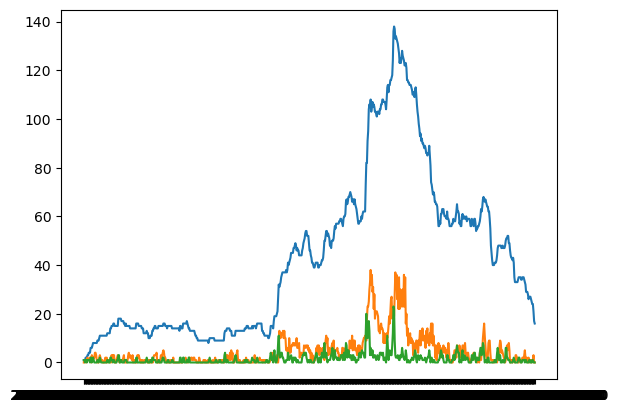

In [10]:
timeline = percent_spread_time(manyfr)


timeline = timeline.sort_values(by = "t")


plt.plot(timeline.t, timeline.num_fires) # blue
plt.plot(timeline.t, timeline.num_spread) # Oragne
plt.plot(timeline.t, timeline.num_ig) # green
#plt.plot(timeline.t, timeline.num_ig + timeline.num_spread )
#timeline.num_spread

[17941.]
Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'func_failed', 'log', 'fline_diff', 'farea_diff',
       'spread_line', 'spread_lineNight', 'spread_lineDay', 'spread_day',
       'GEOS-5_FWI', 'spread_periodNight', 'spread_periodNight_lag_-2',
       'spread_periodNight_lag_-4', 'spread_periodNight_lag_-12',
       'spread_periodNight_lag_-24', 'spread_periodNight_lag_-48',
       'spread_periodDay', 'spread_periodDay_lag_-2',
       'spread_periodDay_lag_-4', 'spread_periodDay_lag_-12',
       'spread_periodDay_lag_-24', 'spread_periodDay_lag_-48'],
      dtype='object')
243368                      NaN
243369                      NaN
243370                      0.0
243371                      0.0
243372                      0.0
243373       1.7332545494228153
243374       2.8746919928593155
243375        6.150092314727241
243376         5.00865487129074
24337

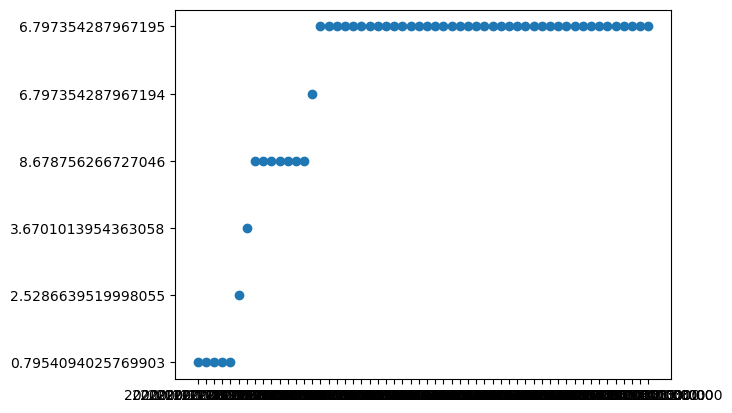

In [19]:
## Find Ids where fire area diff goes negative

weird = manyfr[manyfr.farea_diff.astype("float") < -0.1]
weird_ids = weird.fireID.unique()
print(weird_ids)

weird.t = weird.t.astype("str")
fire = manyfr[manyfr.fireID.astype("float") == float(weird_ids[0])]
print(fire.columns)
plt.scatter(fire.t, fire.farea)
#plt.scatter(fire.t, fire["GEOS-5_FWI"])
print(fire.farea_diff)           
#weird.explore()

In [16]:
## Look at the lag from individual fires. 

#one_id = manyfr.fireID.sample(1)
#float(one_id)
#print(manyfr.fireID.unique())

[   67.   173.   186.   260.   411.   606.   596.   648.   755.  1557.
  1578.  1964.  2311.  2301.  2374.  2518.  2712.  2901.  3044.  3485.
  3788.  3917.  3958.  5080.  5861.  6270.  6739.  6775.  6911.  6969.
  7046.  7495.  7521.  7536.  7540.  7533.  7581.  7656.  7672.  7780.
  7795.  7797.  7807.  7810.  7823.  7814.  7808.  7811.  7863.  7854.
  7851.  7861.  7850.  7896.  7932.  7954.  7976.  7977.  7985.  8043.
  8083.  8225.  8251.  8289.  8276.  8270.  8335.  8390.  8376.  8529.
  8547.  8612.  8746.  8752.  8770.  8796.  8792.  8837.  8809.  8842.
  8861.  8859.  8872.  8887.  8915.  9195.  9230.  9247.  9250.  9280.
  9277.  9314.  9472.  9467.  9504.  9562.  9568.  9578.  9591.  9565.
  9634.  9604.  9606.  9628.  9677.  9675.  9704.  9711.  9772.  9810.
  9861.  9867.  9885.  9903.  9901.  9918.  9932.  9924.  9983. 10003.
  9997. 10010. 10029. 10031. 10098. 10096. 10151. 10239. 10261. 10270.
 10283. 10385. 10383. 10416. 10487. 10491. 10511. 10532. 10523. 10522.
 10507

In [20]:
#11225.0
fire = manyfr[manyfr.fireID.astype("float") == float(one_id)]
print(fire.columns)
plt.scatter(fire.t, fire.farea_diff)
plt.scatter(fire.t, fire["GEOS-5_FWI"])

NameError: name 'one_id' is not defined

Index(['t', 'num_fires', 'num_spread', 'num_ig', 'num_percent_spread',
       'num_percent_spread_ig', 'num_percent_ig', 'fire_labs_all',
       'fire_labs_spread', 'fire_labs_ig', 'area', 'area_spread', 'delta_area',
       'delta_area_spread', 'delta_area_ig', 'area_percent_spread',
       'area_percent_spread_ig', 'area_percent_ig',
       'delta_area_percent_spread', 'delta_area_percent_spread_ig',
       'mean_spread_fwi', 'mean_not_spread_fwi', 'max_spread_fwi'],
      dtype='object')
lag: 36


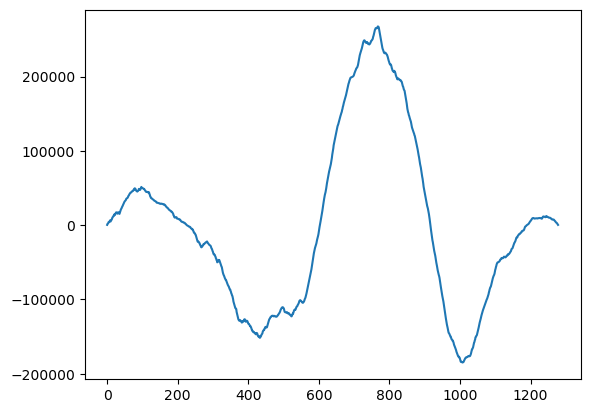

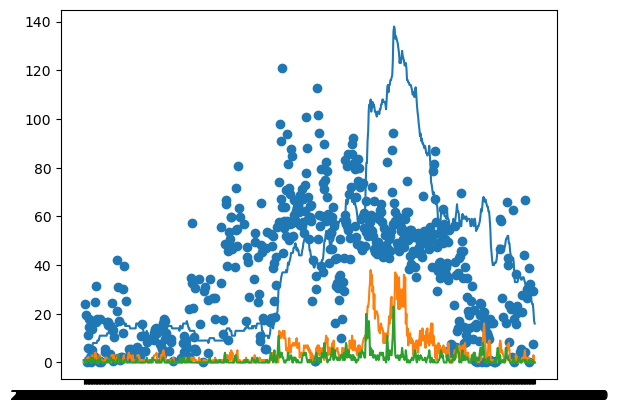

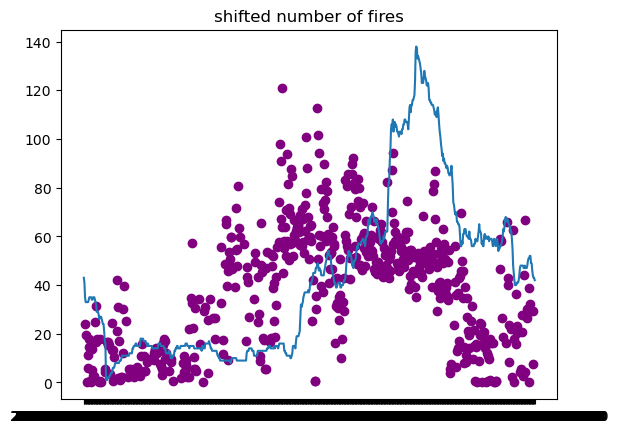

In [11]:
# # create a vector
# vector = np.random.normal(0,1,size=1000) 

# # insert a signal into vector
# #vector[::50]+=10
# vector2 = np.roll(vector, -100)

# vector = vector - np.mean(vector)
# vector2 = vector2 - np.mean(vector2)
# # perform cross-correlation for all data points
# output = np.correlate(vector,vector2,mode='full')

# #plt.plot(output)
# #output
# #?np.correlate
# corr.argmax()

# lag = corr.argmax() - (len(vector) - 1)
# print(lag)


# data_1 = np.sin(np.linspace(0, 10, 100))
# data_1 += np.random.uniform(size=data_1.shape)   # noise
# data_2 = np.cos(np.linspace(0, 7, 70))
# data_2 += np.random.uniform(size=data_2.shape)   # noise
# corr = np.correlate(data_1 - np.mean(data_1), 
#                     data_2 - np.mean(data_2),
#                     mode='full')
# plt.plot(corr)
# plt.show()
# lag = corr.argmax() - (len(data_1) - 1)
# print("the lag is:", lag)
# plt.plot(data_1, 'r*')
# plt.plot(data_2, 'b*')
# plt.plot(np.roll(data_1, -15), 'g*')
# plt.show()


print(timeline.columns)
corr = np.correlate(a = (timeline.num_fires.dropna() - np.mean( timeline.num_fires.dropna())), v = (timeline.max_spread_fwi.dropna() - np.mean(timeline.max_spread_fwi.dropna())), mode = "full")
lag = corr.argmax() - (len(timeline.num_fires.dropna()) - 1)
print("lag:", lag)
plt.plot(corr)
plt.show()

plt.plot(timeline.t, timeline.num_fires) # blue
plt.plot(timeline.t, timeline.num_spread) # Oragne
plt.plot(timeline.t, timeline.num_ig) # green
plt.scatter(timeline.t, timeline.max_spread_fwi)
plt.show()

plt.scatter(timeline.t, timeline.max_spread_fwi, color = "purple")
plt.plot(timeline.t, np.roll(timeline.num_fires, lag)) # blue
plt.title("shifted number of fires")
plt.show()

array([ 1.67108633,  1.1309136 ,  1.25849232,  1.26512768,  1.73263708,
        1.79583306,  1.41727691,  1.11857941,  0.92684147,  1.38545712,
        0.6956198 ,  0.90245407,  0.48017041,  1.19329582,  1.0602915 ,
        0.91467261,  0.2124413 , -0.05275307,  0.46204101,  0.29858739,
       -0.30108806, -0.46276168, -0.42269592, -0.68256946, -0.18539215,
       -0.40874682, -0.70368273, -0.86255727, -0.77321313,  0.0150981 ,
       -0.43480628, -0.49814922, -0.21225027,  0.01877499, -0.66414151,
        0.03459159, -0.75268072, -0.30642421, -0.65651497, -0.23240391,
       -0.42017647,  0.0821994 , -0.19309733,  0.22816346,  0.66993967,
        0.56204987,  0.87143638,  0.82415291,  0.4815206 ,  0.78895262,
        1.12341069,  0.73173317,  0.9031487 ,  0.8631481 ,  1.17059834,
        0.837188  ,  1.41853571,  0.97443324,  1.12590899,  1.19571125,
        1.19028879,  1.32922823,  1.68982333,  1.5931163 ,  1.85899482,
        1.66252557,  1.76300736,  1.66750421,  1.10007384,  0.79

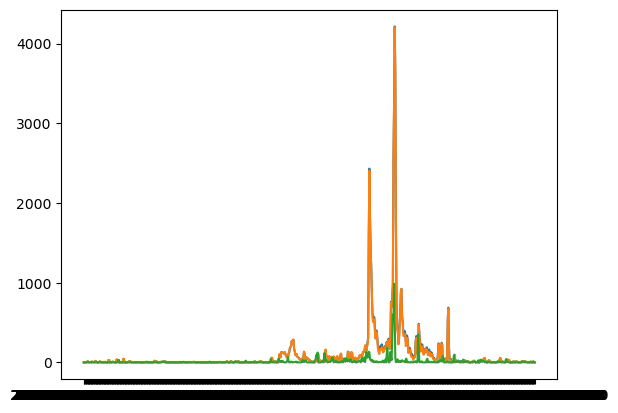

In [12]:


plt.plot(timeline.t, timeline.delta_area.astype("float")) # blue
plt.plot(timeline.t, timeline.delta_area_spread.astype("float")) # Oragne
plt.plot(timeline.t, timeline.delta_area_ig) # green
#plt.plot(timeline.t, timeline.num_ig + timeline.num_spread )
#timeline.num_spread

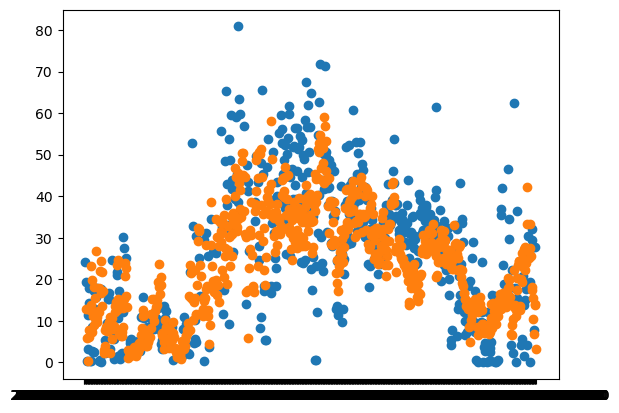

In [13]:
plt.scatter(timeline.t, timeline.mean_spread_fwi) # Blue
plt.scatter(timeline.t, timeline.mean_not_spread_fwi) # oragne

In [ ]:
#plt.scatter(timeline.num_percent_spread, timeline.mean_spread_fwi)

#type(manyfr.t.astype("datetime64[ns]"))

#manyfr_d[manyfr_d.spread_line.astype("str") == "True"].spread_line.unique()
#manyfr_d.spread_line.unique()
manyfr["fireID"]

In [24]:


manyfr_d = manyfr[manyfr.t.astype("datetime64[ns]").dt.hour > 0] #daytime only, so the farea_diff can't be larger than 100

final_a = []
for i in manyfr.fireID.unique(): 
    #print(i)
    try:
        final_area = max(manyfr_d.farea.astype("float")[manyfr_d.fireID == i])
    except:
        next
    else:
        spread_area = sum(manyfr_d[(manyfr_d.fireID == i) & (manyfr_d.spread_line.astype("str") == "True")].farea_diff.astype("float")) ## Includes both spread days and ignitions bc 2 is interprested as true
        ignition_area = max(manyfr_d[(manyfr_d.fireID == i) & (manyfr_d.spread_line.astype("str") == "2")].farea.astype("float"))
        percent_spread = spread_area / final_area
        percent_ignition = ignition_area / final_area
        final_a.append([i, final_area, spread_area, ignition_area, percent_spread, percent_ignition])
        #final_a.append([i, final_area, spread_area, percent_spread, ])
        
        

In [25]:

tmp = []
tmp = pd.DataFrame(data = final_a, columns = ["Id", "Final_area", "spread_area", "ignition_area", "percent_spread", "percent_ignition"])

tmp

Id  Final_area   spread_area  ignition_area  percent_spread  \
0       67.0    8.569367  6.735098e+00       0.413636    7.859505e-01   
1      173.0    8.507914  4.735807e+00       1.980119    5.566355e-01   
2      186.0   18.860567  1.454859e+01       1.669493    7.713762e-01   
3      260.0    5.364177  4.849292e+00       0.514886    9.040141e-01   
4      411.0   13.602687  1.207439e+01       0.896261    8.876477e-01   
..       ...         ...           ...            ...             ...   
461  20066.0    4.988421  3.871932e+00       1.116489    7.761839e-01   
462  20084.0    5.696567  5.476029e+00       0.141000    9.612857e-01   
463  20175.0   32.149973  2.353774e+01       8.612230    7.321233e-01   
464  20216.0    5.300283  6.081795e-08       5.300283    1.147447e-08   
465  20435.0    5.134330  2.840224e+00       2.294106    5.531830e-01   

     percent_ignition  
0            0.048269  
1            0.232739  
2            0.088518  
3            0.095986  
4            0.065889  
..                ...  
461          0.223816  
462          0.024752  
463          0.267877  
464          1.000000  
465          0.446817  

[466 rows x 6 columns]

In [26]:
print(len(tmp))
tmp = tmp[tmp.percent_spread <= 1]
print(len(tmp[tmp.percent_spread <= 1]))


print( sum(tmp.spread_area)/sum(tmp.Final_area)) ## Comes out to larger than 100???? Need to manually exclude numerical weirdnesses
print("Ignition percent: ",  sum(tmp.ignition_area)/sum(tmp.Final_area))


466
466
0.8445155607963928
Ignition percent:  0.11848976104603


In [27]:
#tmp[tmp.percent_spread >= 1]

#29/(426)

0.5966125361740525

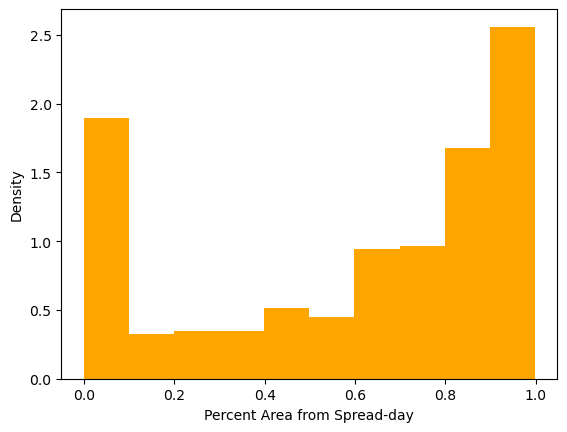

In [28]:
plt.hist(tmp.percent_spread, density= True, color = "orange")
plt.ylabel("Density")
plt.xlabel("Percent Area from Spread-day")

np.mean(tmp.percent_spread)

0.35752553984007324

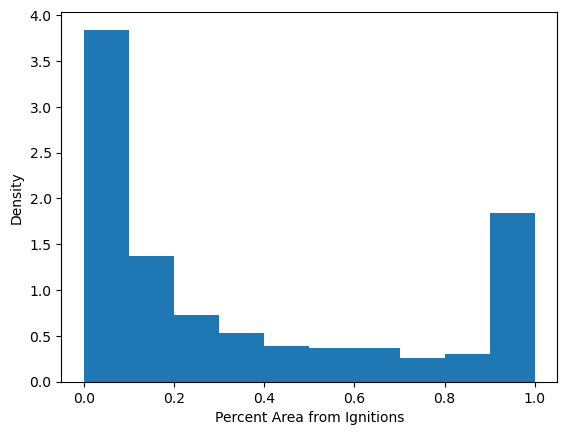

In [29]:
plt.hist(tmp.percent_ignition, density= True)
plt.ylabel("Density")
plt.xlabel("Percent Area from Ignitions")

np.mean(tmp.percent_ignition)

Text(0.5, 0, 'Fire Size')

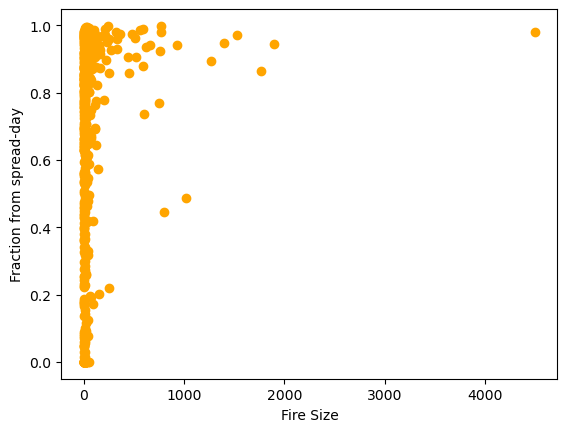

In [31]:
plt.scatter(tmp.Final_area, tmp.percent_spread, color = "orange")
plt.ylabel("Fraction from spread-day")
plt.xlabel("Fire Size")

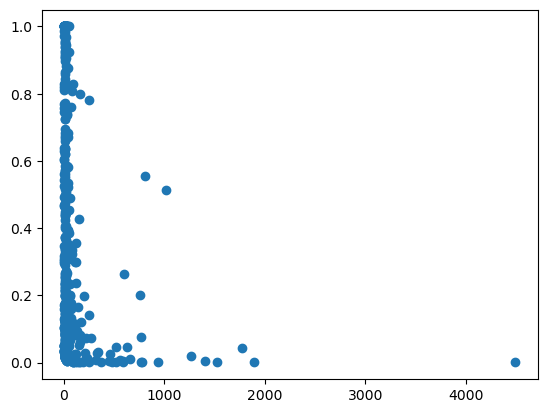

In [32]:
plt.scatter(tmp.Final_area, tmp.percent_ignition)

In [33]:
manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"]

208616    0.374047
208617    0.418254
208621     0.40554
208622    0.347106
9963           NaN
            ...   
138543         NaN
82673          0.0
82674     0.000001
138552         NaN
150336         NaN
Name: GEOS-5_FWI, Length: 3027, dtype: object

In [34]:
# #plt.hist(manyfr["GEOS-5_FWI"], c = manyfr.spread_line )

# #bins = np.linspace(0, max(manyfr["GEOS-5_FWI"].dropna()), 40)
# #bins

# spread_n = str(len(manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"]))
# n_spread_n = str(len(manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "False"]))
# ig_n = str(len(manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "2"]))

# plt.hist([manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"], 
#           manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "False"], 
#           manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "2"]], 
#          label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  
#          density = True)
# plt.legend(loc='upper right')
# plt.show()

In [37]:
#spread_n

In [ ]:
### Create shifted weather data. 
# manyfr = manyfr.sort_values(by = ["t"])
# manyfr["fwilag_24"] = manyfr["GEOS-5_FWI"].shift(2)

# manyfr

In [ ]:
#bins = np.linspace(0, max(manyfr["GEOS-5_FWI"].dropna()), 40)

# spread_n = str(len(manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "1"]))
# n_spread_n = str(len(manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "0"]))
# ig_n = str(len(manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "2"]))

# plt.hist([manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "1"], manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "0"], manyfr["fwilag_24"][manyfr.spread_line.astype("str") == "2"]],label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n],  density = True)
# plt.legend(loc='upper right')
# plt.show()

In [34]:
#len(manyfr["GEOS-5_FWI"])

25079

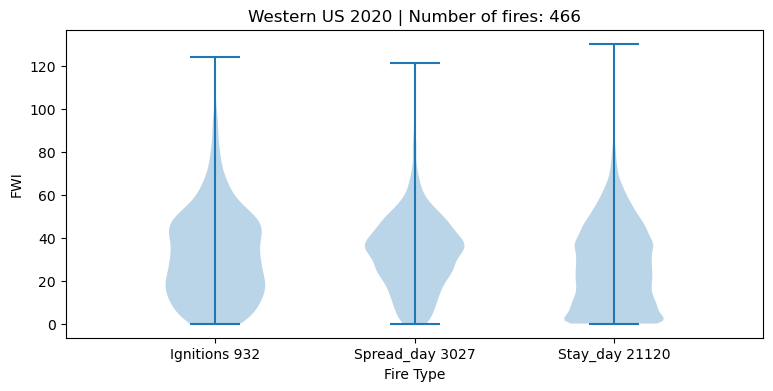

In [75]:
### Different becuase of hourly data????????. Nope, Was looking at FFMC before, not FWI. Need more climate vars to look at. 


spread_n = str(len(manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"]))
n_spread_n = str(len(manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "False"]))
ig_n = str(len(manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "2"]))
#ig_days


sprd_days = manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"].astype("float").dropna().to_numpy()
st_days = manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "False"].astype("float").dropna().to_numpy()
ig_days = manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "2"].astype("float").dropna().to_numpy()
               
# violin_df = pd.DataFrame(data = [sprd_days, st_days, ig_days], 
#                 columns = ["Spread-days", "Stay-days", "Ignitions"])

# plt.violinplot( dataset = [sprd_days, st_days, ig_days]
#                 ) #label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n], density = True
#plt.legend(loc='upper right')
# plt.show()
#violin_df
#manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"].values
#manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "0"]
#manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "2"] 
#sprd_days         

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Fire Type')

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

ax1.set_title('Western US 2020 |' + " Number of fires: " + str(len(manyfr.fireID.unique())))
ax1.set_ylabel('FWI')
ax1.violinplot([ig_days, sprd_days, st_days ])

labels = ["Ignitions" + " " + ig_n, 'Spread_day' + " " + spread_n, 'Stay_day' + " " + n_spread_n ]

set_axis_style(ax1, labels)

In [76]:
ig_days

array([3.41011733e-01, 3.58410865e-01, 1.96890867e+00, 3.34044933e+00,
       2.62315273e-01, 2.05288023e-01, 4.16770011e-01, 2.89680004e-01,
       4.24058819e+00, 9.20397758e+00, 9.81756878e+00, 4.30852032e+00,
       3.66677356e+00, 4.34710217e+00, 7.24439621e+00, 4.21630764e+00,
       1.32619429e+01, 1.03219643e+01, 2.52809620e+00, 5.75854301e+00,
       8.19994545e+00, 1.92531147e+01, 2.55162849e+01, 1.34361714e-01,
       4.00637269e-01, 2.70425618e-01, 8.95231009e-01, 6.79699898e-01,
       5.27280331e+00, 2.62077188e+00, 2.28720512e+01, 2.58975010e+01,
       7.92216682e+00, 1.07473955e+01, 4.21964378e+01, 3.76361885e+01,
       4.99218254e+01, 4.63537636e+01, 2.80965042e+01, 3.33247757e+01,
       4.69944458e+01, 5.20229759e+01, 4.49008331e+01, 5.00902023e+01,
       1.93006382e+01, 1.32520151e+01, 6.49416504e+01, 3.72484131e+01,
       5.34038239e+01, 2.77580566e+01, 1.45668154e+01, 2.20589399e+00,
       3.84195557e+01, 6.27946243e+01, 2.53348999e+01, 6.79690170e+00,
      

In [81]:
import scipy.stats as st

print(st.kstest(st_days, sprd_days))
print(st.kstest(st_days, ig_days))
print(st.kstest(ig_days, sprd_days))

print(np.mean(st_days))
print(np.mean(sprd_days))
print(np.mean(ig_days))
# for i, pc in enumerate(fig["bodies"], 1):
#     if i == 0:
#         pc.set_facecolor('green')
#     if i == 1:
#         pc.set_facecolor('#fe953e')
#     if i == 2:
#         pc.set_facecolor('#2f7fb9')
#     pc.set_edgecolor('black')

   # 'stay-day': '#2f7fb9','spread-day':'#fe953e'

In [87]:
#ks = st.kstest(st_days, sprd_days)
ks[1]

7.409679948791461e-23

In [54]:
manyfr[['t','meanFRP',   'spread_line','spread_lineNight', 'spread_periodNight_lag_-2', 'spread_lineDay','spread_periodDay_lag_-2']]
#manyfr.columns

t   meanFRP spread_line spread_lineNight  \
208614  2020-01-02 12:00:00  3.843333           2              NaN   
208615  2020-01-03 00:00:00  0.376667           2                2   
208616  2020-01-03 12:00:00  6.981596        True              NaN   
208617  2020-01-04 00:00:00       0.0        True             True   
208618  2020-01-04 12:00:00       0.0       False              NaN   
...                     ...       ...         ...              ...   
138556  2020-12-31 12:00:00       0.0       False              NaN   
29800   2020-12-31 12:00:00       0.0       False              NaN   
150338  2020-12-31 12:00:00       0.0       False              NaN   
158732  2020-12-31 12:00:00       0.0       False              NaN   
261683  2020-12-31 12:00:00       0.0       False              NaN   

       spread_periodNight_lag_-2 spread_lineDay spread_periodDay_lag_-2  
208614                      True              2                    True  
208615                      True            NaN                   False  
208616                     False           True                   False  
208617                     False            NaN                   False  
208618                      True          False                   False  
...                          ...            ...                     ...  
138556                       NaN          False                    True  
29800                        NaN          False                     NaN  
150338                       NaN          False                     NaN  
158732                       NaN          False                   False  
261683                       NaN          False                     NaN  

[25079 rows x 7 columns]

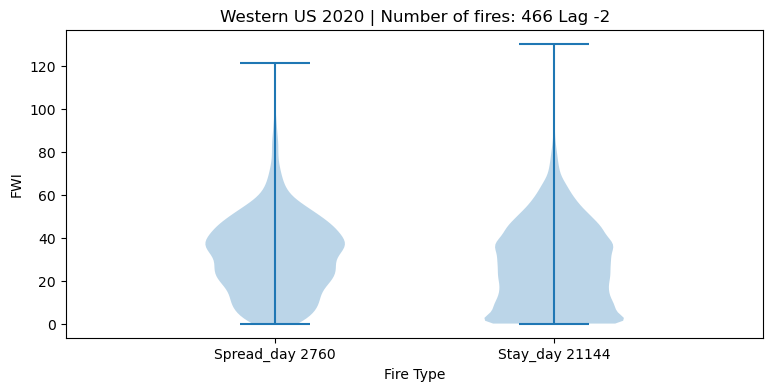

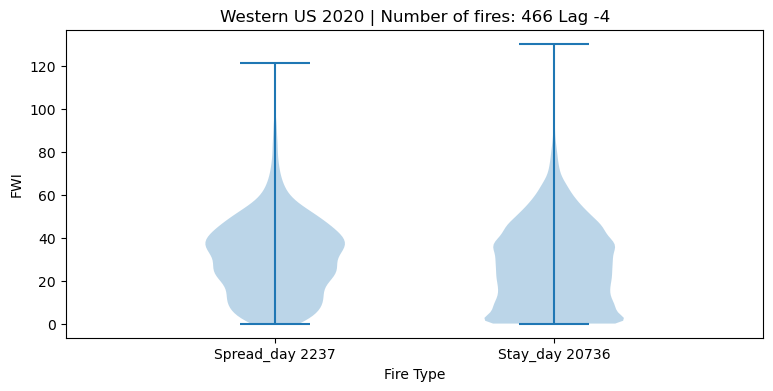

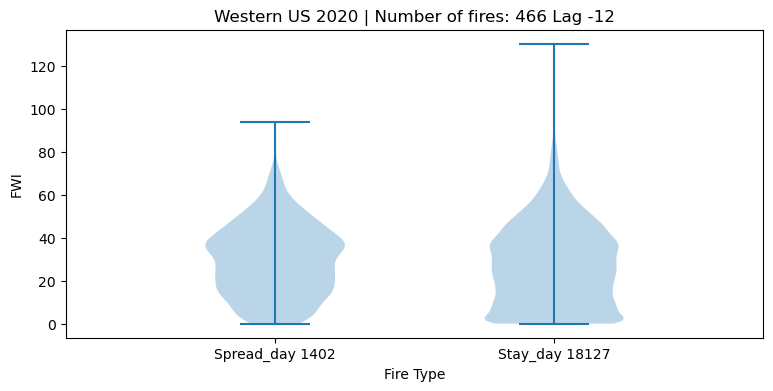

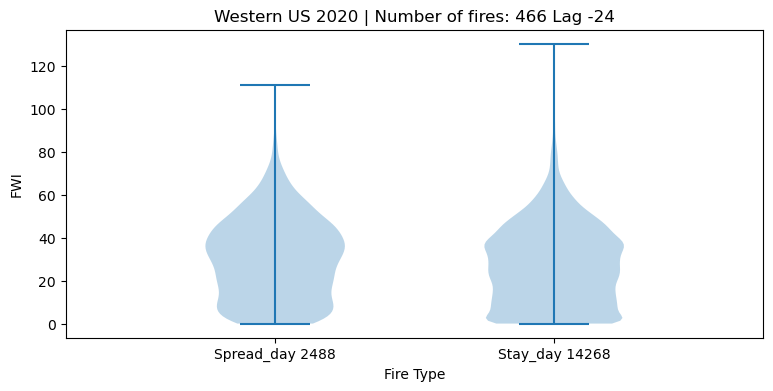

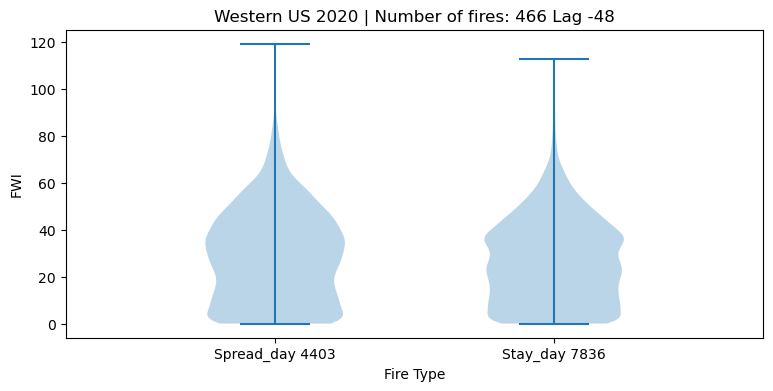

In [67]:
### Look at a bunch of lags 'spread_periodNight_lag_-4' <--- SAMPLING ISSUES. NOT GETTING THE PERIOD BEFORE IGNITION. 

lags = [-2,-4,-12,-24,-48]

lag_name = "spread_periodNight_lag_"

for l in lags:
    
    spread_n = str(len(manyfr["GEOS-5_FWI"][manyfr[lag_name + str(l)].astype("str") == "True"]))
    n_spread_n = str(len(manyfr["GEOS-5_FWI"][manyfr[lag_name + str(l)].astype("str") == "False"]))
    #ig_n = str(len(manyfr["GEOS-5_FWI"][manyfr[lag_name + str(l)].astype("str") == "2"]))
    #ig_days


    sprd_days = manyfr["GEOS-5_FWI"][manyfr[lag_name + str(l)].astype("str") == "True"].astype("float").dropna().to_numpy()
    st_days = manyfr["GEOS-5_FWI"][manyfr[lag_name + str(l)].astype("str") == "False"].astype("float").dropna().to_numpy()
    i#g_days = manyfr["GEOS-5_FWI"][manyfr[lag_name + str(l)].astype("str") == "2"].astype("float").dropna().to_numpy()


    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    ax1.set_title('Western US 2020 |' + " Number of fires: " + str(len(manyfr.fireID.unique())) + " Lag " + str(l))
    ax1.set_ylabel('FWI')
    #ax1.violinplot([ig_days, sprd_days, st_days ])
    ax1.violinplot([sprd_days, st_days ])

    #labels = ["Ignitions" + " " + ig_n, 'Spread_day' + " " + spread_n, 'Stay_day' + " " + n_spread_n ]
    labels = ['Spread_day' + " " + spread_n, 'Stay_day' + " " + n_spread_n ]

    set_axis_style(ax1, labels)

In [46]:
#manyfr.columns

Index(['Unnamed: 0', 'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen',
       'duration', 'pixden', 'meanFRP', 't', 'geometry', 'lon', 'lat',
       'fireID', 'func_failed', 'log', 'fline_diff', 'farea_diff',
       'spread_line', 'spread_lineNight', 'spread_lineDay', 'spread_day',
       'GEOS-5_FWI', 'spread_periodNight', 'spread_periodNight_lag_-2',
       'spread_periodNight_lag_-4', 'spread_periodNight_lag_-12',
       'spread_periodNight_lag_-24', 'spread_periodNight_lag_-48',
       'spread_periodDay', 'spread_periodDay_lag_-2',
       'spread_periodDay_lag_-4', 'spread_periodDay_lag_-12',
       'spread_periodDay_lag_-24', 'spread_periodDay_lag_-48'],
      dtype='object')

In [43]:
### Check if static source filtering had anything to do with the discreprency (Seems similar)

# unsortfr = pd.read_csv("/projects/my-public-bucket/fire_spread/WesternUS_REDO_all_2020_2023-03-29dask_mega_function.csv")

# unsortfr["func_failed"].unique()
# unsortfr = unsortfr[(unsortfr["func_failed"] != 'load_large_fire/get_gpm')  ]


# #plt.scatter(manyfr[manyfr.fireID.astype("str") == "117"].t, manyfr[manyfr.fireID.astype("str") == "117"].farea)
# unsortfr = unsortfr[unsortfr.n_pixels.notna()]
# unsortfr = unsortfr.sort_values(by = ["t"])

# unsortfr.geometry =unsortfr.geometry.apply(wkt.loads)
# unsortfr = gpd.GeoDataFrame(unsortfr, geometry = "geometry")

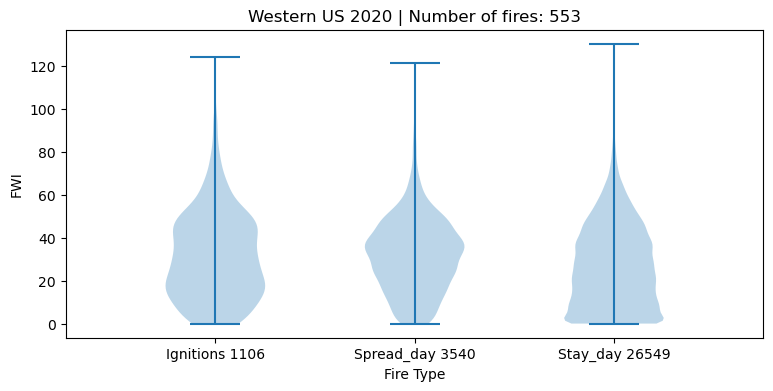

In [45]:
# spread_n = str(len(unsortfr["GEOS-5_FWI"][unsortfr.spread_line.astype("str") == "True"]))
# n_spread_n = str(len(unsortfr["GEOS-5_FWI"][unsortfr.spread_line.astype("str") == "False"]))
# ig_n = str(len(unsortfr["GEOS-5_FWI"][unsortfr.spread_line.astype("str") == "2"]))
# #ig_days


# sprd_days = unsortfr["GEOS-5_FWI"][unsortfr.spread_line.astype("str") == "True"].astype("float").dropna().to_numpy()
# st_days = unsortfr["GEOS-5_FWI"][unsortfr.spread_line.astype("str") == "False"].astype("float").dropna().to_numpy()
# ig_days = unsortfr["GEOS-5_FWI"][unsortfr.spread_line.astype("str") == "2"].astype("float").dropna().to_numpy()
               
# # violin_df = pd.DataFrame(data = [sprd_days, st_days, ig_days], 
# #                 columns = ["Spread-days", "Stay-days", "Ignitions"])

# # plt.violinplot( dataset = [sprd_days, st_days, ig_days]
# #                 ) #label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n], density = True
# #plt.legend(loc='upper right')
# # plt.show()
# #violin_df
# #manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "True"].values
# #manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "0"]
# #manyfr["GEOS-5_FWI"][manyfr.spread_line.astype("str") == "2"] 
# #sprd_days         



# fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

# ax1.set_title('Western US 2020 |' + " Number of fires: " + str(len(unsortfr.fireID.unique())))
# ax1.set_ylabel('FWI')
# ax1.violinplot([ig_days, sprd_days, st_days ])

# labels = ["Ignitions" + " " + ig_n, 'Spread_day' + " " + spread_n, 'Stay_day' + " " + n_spread_n ]

# set_axis_style(ax1, labels)

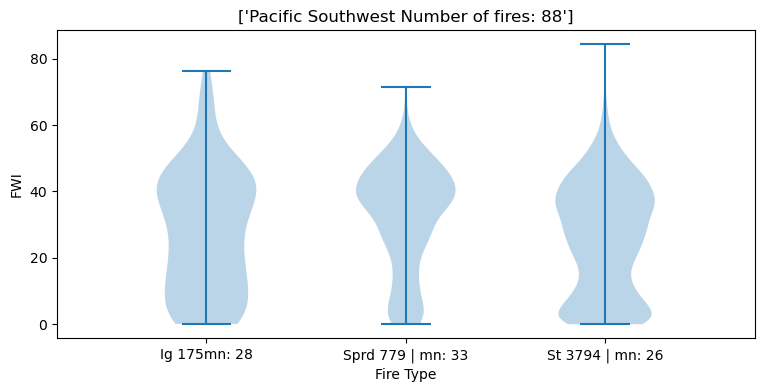

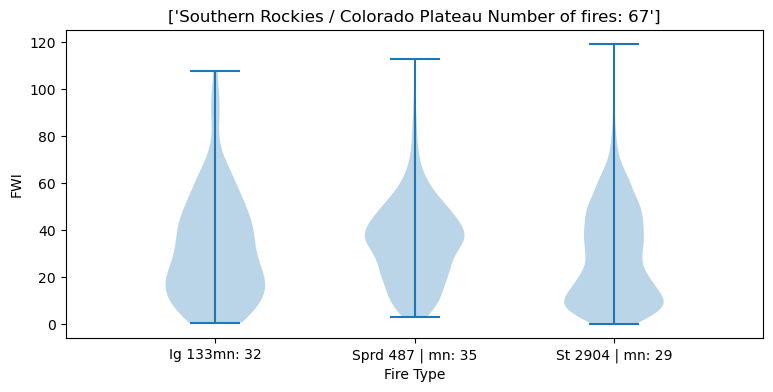

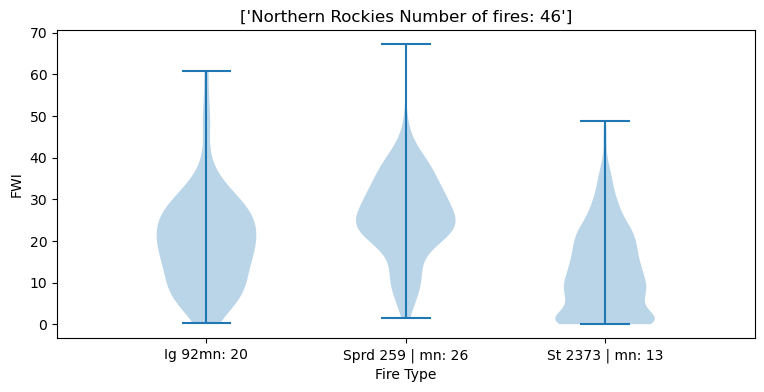

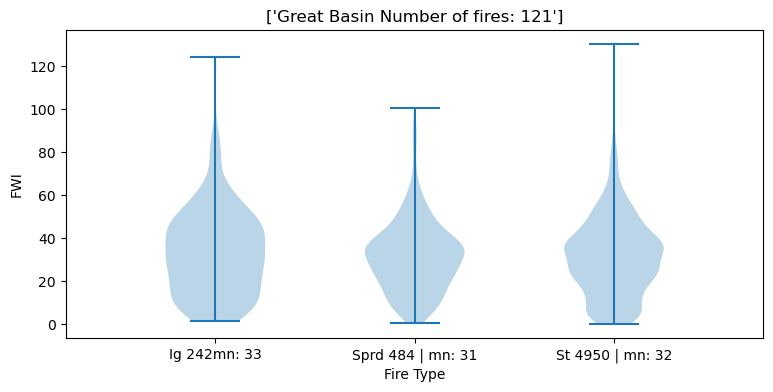

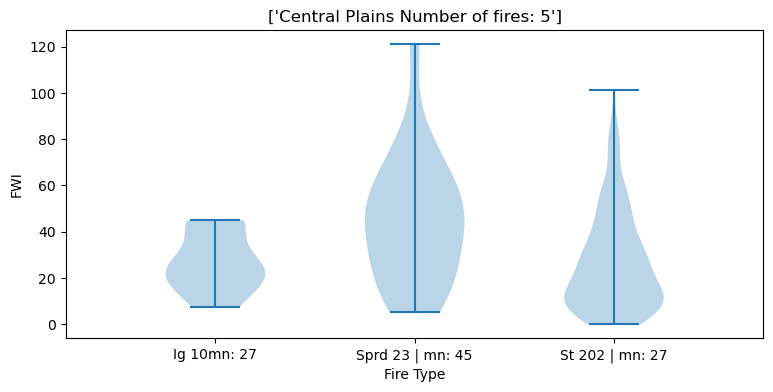

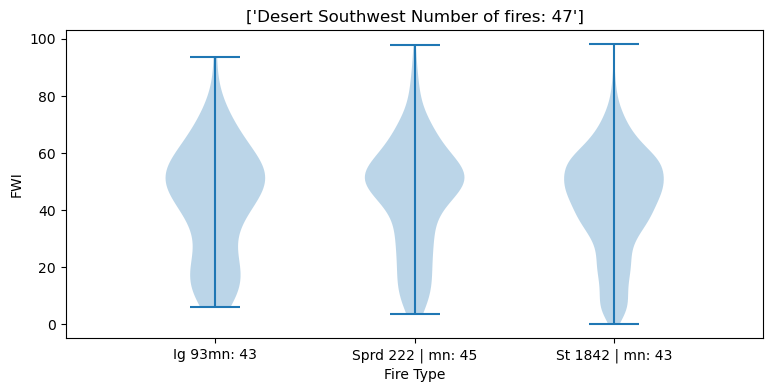

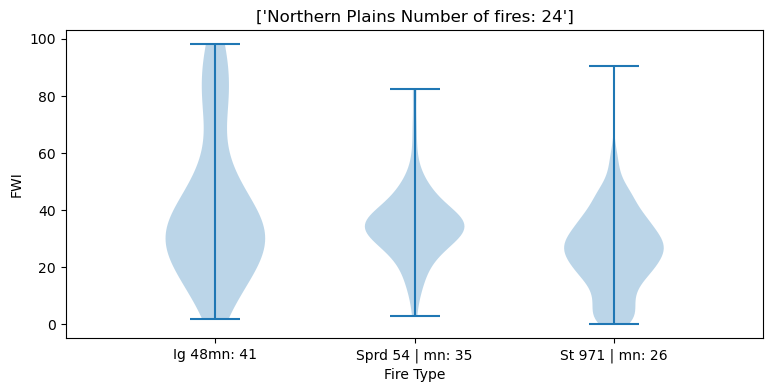

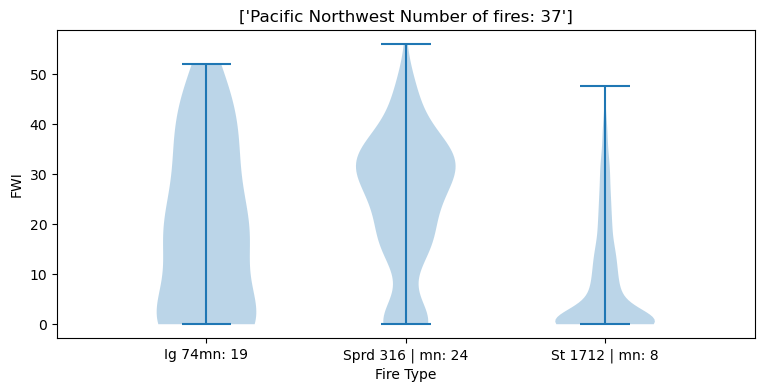

In [100]:
## Check regionally

regions = joinfr.DomainID.unique()

for r in regions:
    regionfr = joinfr[joinfr.DomainID == r]
    spread_n = str(len(regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "True"]))
    n_spread_n = str(len(regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "False"]))
    ig_n = str(len(regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "2"]))
    #ig_days


    sprd_days = regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "True"].astype("float").dropna().to_numpy()
    st_days = regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "False"].astype("float").dropna().to_numpy()
    ig_days = regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "2"].astype("float").dropna().to_numpy()

    # violin_df = pd.DataFrame(data = [sprd_days, st_days, ig_days], 
    #                 columns = ["Spread-days", "Stay-days", "Ignitions"])

    # plt.violinplot( dataset = [sprd_days, st_days, ig_days]
    #                 ) #label=['spread_day' + " " + spread_n, 'stay_day' + " " + n_spread_n, "ignitions" + " " + ig_n], density = True
    #plt.legend(loc='upper right')
    # plt.show()
    #violin_df
    #regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "True"].values
    #regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "0"]
    #regionfr["GEOS-5_FWI"][regionfr.spread_line.astype("str") == "2"] 
    #sprd_days         
    st_spd = st.kstest(st_days, sprd_days)
    st_ig = st.kstest(st_days, ig_days)
    ig_spd = st.kstest(ig_days, sprd_days)
    tests = [st_spd, st_ig, ig_spd]
    names = ["Stay vs Spread", "Stay vs Ignitions", "Ignitions vs Spread"]
    
    sigs = []
    for i,p in enumerate(tests, start = 0):
        pval = p[1]/21
        if(pval < 0.05):
            sigs.append(names[i])
            

    #np.mean(st_days)
    #print(np.mean(sprd_days))
    #print(np.mean(ig_days))

    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    #ax1.set_title(regionfr.DomainName.unique() + " Number of fires: " + str(len(regionfr.fireID.unique())) + str(sigs))
    ax1.set_title(regionfr.DomainName.unique() + " Number of fires: " + str(len(regionfr.fireID.unique())))
    ax1.set_ylabel('FWI')
    ax1.violinplot([ig_days, sprd_days, st_days ])
    labels = ["Ig" + " " + ig_n + " | mean: " + str(round(np.mean(ig_days))), 'Sprd' + " " + spread_n + " | mean: " + str(round(np.mean(sprd_days))), 'St' + " " + n_spread_n + " | mean: " + str(round(np.mean(st_days)))]

    set_axis_style(ax1, labels)


In [45]:
#len(sprd_days)

In [ ]:
# manyfr = manyfr.sort_values(by = ["t"])
# manyfr["fwilag_24"] = manyfr["GEOS-5_FWI"].shift(2)

# manyfr

# manyfr.spread_line[manyfr.spread_line == "True"] = 1
# manyfr.spread_line[manyfr.spread_line == "False"] = 0

# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(manyfr.t, np.log(manyfr.farea), c = manyfr.spread_line.astype("int"))
# ax.set_ylabel("Logged Fire Area", color = "purple")
# ax2=ax.twinx()
# ax2.plot(manyfr.t, manyfr.fwilag_24, alpha = 0.3)

# ax2.set_ylabel("FWI",color="blue")

In [ ]:
# # lag = 2

# timeline = timeline.set_index("t")
# #timeline["t"] = timeline.set_index

# # timeline["lag_spread_fwi"] = timeline.mean_spread_fwi.shift(lag)
# # timeline["lag_not_spread_fwi"] = timeline.mean_not_spread_fwi.shift(lag)

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
# legend = ax.legend(loc='upper right', fontsize='small')
# ax.set_ylabel("Number of fires", color = "Black")
# ax2=ax.twinx()
# #ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
# #ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
# ax2.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")

# ax2.set_ylabel("Max FWI",color="purple")

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
# legend = ax.legend(loc='upper right', fontsize='small')
# ax.set_ylabel("Number of fires", color = "Black")
# ax2=ax.twinx()
# #ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
# #ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
# ax2.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")

# ax2.set_ylabel("Max FWI",color="purple")

In [ ]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")
# ax.set_ylabel("Max FWI", color = "Purple")

# ax2=ax.twinx()
# ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.area, label = "Total Fire Area")
# ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.area_spread, label = "Spreading Fire Area")
# ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area_ig, label = "Igniting Fire Area")
# legend = ax2.legend(loc='upper right', fontsize='small')
# ax2.set_ylabel("Fire Area")

# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_fires, label = "Total Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_spread, label = "Spreading Fires")
# ax.plot(timeline.index.astype("datetime64[ns]"), timeline.num_ig, label = "Igniting Fires")
# legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
# ax.set_ylabel("Number of fires", color = "Black")
# ax2=ax.twinx()
# #ax2.scatter(timeline.t, timeline["lag_not_spread_fwi"], alpha = 0.3)
# #ax2.scatter(timeline.index, timeline["lag_spread_fwi"], alpha = 0.3, color = "purple")
# ax2.scatter(timeline.index.astype("datetime64[ns]"), timeline.mean_spread_fwi, alpha = 0.3, color = "purple")

# ax2.set_ylabel("Mean FWI",color="purple")

In [46]:
# fig, ax = plt.subplots(figsize=(12,8))
# ax.scatter(timeline.index.astype("datetime64[ns]"), timeline.max_spread_fwi, alpha = 0.3, color = "purple")
# ax.set_ylabel("Max FWI", color = "Purple")

# ax2=ax.twinx()
# ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area, label = "Total Fire Area")
# ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area_spread, label = "Spreading Fire Area")
# ax2.plot(timeline.index.astype("datetime64[ns]"), timeline.delta_area_ig, label = "Igniting Fire Area")
# legend = ax2.legend(loc='upper right', fontsize='small')
# ax2.set_ylabel("Cummulative Fire Area")


In [ ]:
# lag = 2

# manyfr = manyfr.sort_values(by = ["t"])
# manyfr["fwilag_24"] = manyfr["GEOS-5_FWI"].shift(lag)

# manyfr

# manyfr.spread_line[manyfr.spread_line == "True"] = 1
# manyfr.spread_line[manyfr.spread_line == "False"] = 0

# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(timeline.index, timeline.num_fires)
# ax.plot(timeline.index, timeline.num_spread)
# ax.plot(timeline.index, timeline.num_ig)
# ax.set_ylabel("Number of fires", color = "black")
# ax2=ax.twinx()
# ax2.plot(manyfr.t, manyfr.fwilag_24, alpha = 0.3)

# ax2.set_ylabel("FWI",color="purple")

In [38]:
# lag = 4

# manyfr = manyfr.sort_values(by = ["t"])
# manyfr["fwilag_24"] = manyfr["GEOS-5_FWI"].shift(lag)

# manyfr

# manyfr.spread_line[manyfr.spread_line == "True"] = 1
# manyfr.spread_line[manyfr.spread_line == "False"] = 0

# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(timeline.index, timeline.delta_area)
# ax.plot(timeline.index, timeline.delta_area_spread)
# ax.plot(timeline.index, timeline.delta_area_ig)
# ax.set_ylabel("Fire Area", color = "purple")
# ax2=ax.twinx()
# ax2.plot(manyfr.t, manyfr.fwilag_24, alpha = 0.3)

# ax2.set_ylabel("FWI",color="blue")

In [39]:
#manyfr.spread_line[manyfr.spread_line == "True"] = 1
#manyfr.spread_line[manyfr.spread_line == "False"] = 0

# fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(manyfr.t, manyfr["GEOS-5_FWI"], alpha = 0.2, color = "purple")
# ax.set_ylabel("FWI",color="purple")

# ax2=ax.twinx()
# ax2.plot(timeline.index, timeline.delta_area)
# ax2.plot(timeline.index, timeline.delta_area_spread)
# ax2.plot(timeline.index, timeline.delta_area_ig)
# ax2.set_ylabel("Fire Area", color = "Orange")

In [81]:
## Make fake "farea growth" taking into account ignitions

manyfr["fgrowth_merge"] = manyfr["farea_diff"]

manyfr.fgrowth_merge[(manyfr.spread_line.astype("str") == "2")] = manyfr[manyfr.spread_line.astype("str") == "2"].farea

manyfr[["GEOS-5_FWI", "farea", "farea_diff", "spread_line", "fgrowth_merge"]]

GEOS-5_FWI               farea farea_diff spread_line  \
208614           0.341012            0.413636        NaN           2   
208615           0.358411            1.281363        NaN           2   
208616           0.374047             4.61519   4.201554        True   
208617           0.418254             4.61519   3.333828        True   
208618           0.322105             4.61519        0.0       False   
...                   ...                 ...        ...         ...   
138556                NaN           32.149973        0.0       False   
29800            1.172096           16.816863        0.0       False   
150338                NaN   5.134330064786509        0.0       False   
158732                NaN   6.409607088231584        0.0       False   
261683  1.644666314125061  11.675226531942942        0.0       False   

       fgrowth_merge  
208614      0.413636  
208615      1.281363  
208616      4.201554  
208617      3.333828  
208618           0.0  
...              ...  
138556           0.0  
29800            0.0  
150338           0.0  
158732           0.0  
261683           0.0  

[25079 rows x 5 columns]

In [85]:
#manyfr[manyfr[night_lag_string] == True]["GEOS-5_FWI"].dropna()
#scipy.stats.linregress(manyfr[manyfr[night_lag_string] == True]['GEOS-5_FWI'], manyfr[manyfr[night_lag_string] == True].farea_diff)
#manyfr[manyfr[night_lag_string] == True].farea_diff

#plt.scatter(manyfr[manyfr[night_lag_string] == True].farea_diff, manyfr[manyfr[night_lag_string] == True]["GEOS-5_FWI"])
#plt.scatter(timefr1[timefr1[night_lag_string] == True]['GEOS-5_FWI'], timefr1[timefr1[night_lag_string] == True].farea_diff)

In [83]:
#manyfr.filter(like='spread_period', axis=1).columns
#timefr1
#scipy.stats.linregress

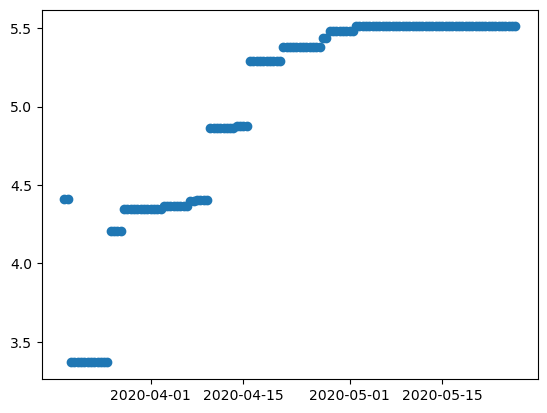

In [120]:
# tmp = manyfr[manyfr.fireID.isin([3773, ])] # 9250, 7976, 5834
# plt.scatter(tmp.t.astype("datetime64[ns]"), tmp.farea.astype(float))

# from shapely import wkt

# tmp.geometry = tmp.geometry.apply(wkt.loads)
# tmp = gpd.GeoDataFrame(tmp, geometry = "geometry")
# #tmp.explore()

           Lag  0  had an R squared of:  0.17212802576480885
FOR day: Lag  0  had an R squared of:  0.17675300451516573
Lag  0  had an pval of:  3.444020417304545e-05


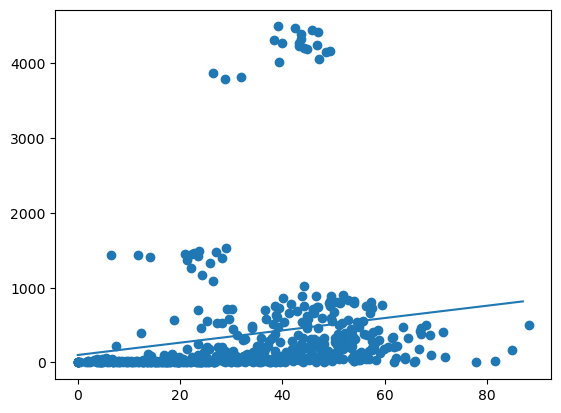

           Lag  -2  had an R squared of:  0.1794461866475162
FOR day: Lag  -2  had an R squared of:  0.18461959966471586
Lag  -2  had an pval of:  1.6979678999476414e-05


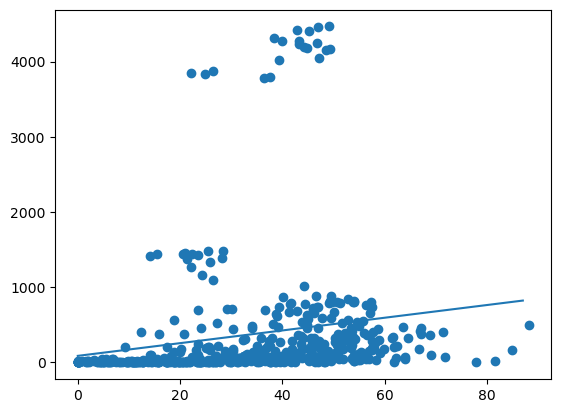

           Lag  -4  had an R squared of:  0.1632608257180172
FOR day: Lag  -4  had an R squared of:  0.17135976683390683
Lag  -4  had an pval of:  9.296024675206255e-05


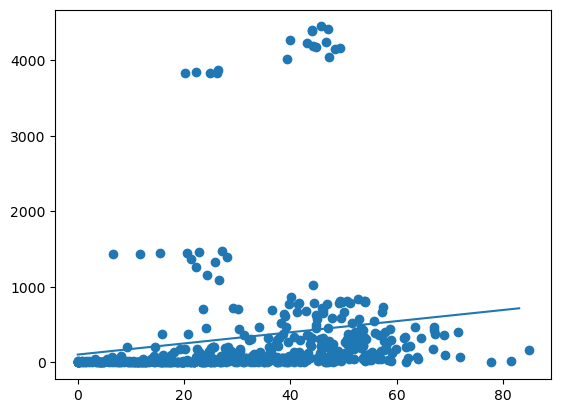

           Lag  -12  had an R squared of:  0.08846563570980476
FOR day: Lag  -12  had an R squared of:  0.10586730791588601
Lag  -12  had an pval of:  0.04501224082853963


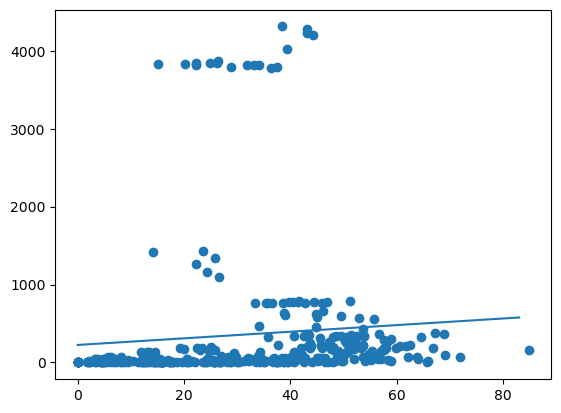

           Lag  -48  had an R squared of:  0.7206428472147506
FOR day: Lag  -48  had an R squared of:  0.6709217434419201
Lag  -48  had an pval of:  5.251837709669656e-08


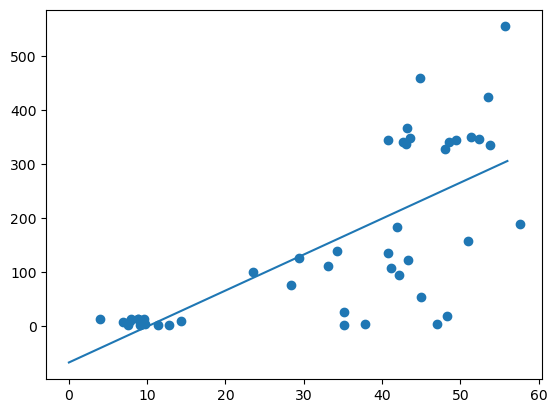

In [108]:
### Test a bunch of lags
import scipy.stats

lags = [0, -2, -4, -12, -48]
lag_reg = []

for l in lags:

    timefr = manyfr.set_index("t")
    #timefr = timefr[timefr.farea_diff.astype("float") > 0]
    timefr1 = timefr[["GEOS-5_FWI","farea", *manyfr.filter(like='spread_period', axis=1).columns]].dropna()
    timefr2 = timefr[["GEOS-5_FWI", "fgrowth_merge", *manyfr.filter(like='spread_period', axis=1).columns]].dropna()

    if(l == 0):
        night_lag_string = "spread_periodNight"
        day_lag_string = "spread_periodDay"
        
    else:
        night_lag_string = "spread_periodNight_lag_" + str(l)
        day_lag_string = "spread_periodDay_lag_" + str(l)
    #print(len(lag_test))
    diff_pr = scipy.stats.linregress(x = timefr1[timefr1[night_lag_string] == True]['GEOS-5_FWI'].astype("float"), y = timefr1[timefr1[night_lag_string] == True].farea.astype("float"))
    #merge_pr = scipy.stats.linregress(x = timefr2[timefr2[night_lag_string] == True]['GEOS-5_FWI'].astype("float"), y = timefr2[timefr2[night_lag_string] == True].fgrowth_merge.astype("float"))
    day_pr = scipy.stats.linregress(x = timefr1[timefr1[day_lag_string] == True]['GEOS-5_FWI'].astype("float"), y = timefr1[timefr1[day_lag_string] == True].farea.astype("float"))

    
    print("           Lag " , l ,  " had an R squared of: ", diff_pr.rvalue)
    print("FOR day: Lag " , l ,  " had an R squared of: ", day_pr.rvalue)
    lag_reg.append([l, str(diff_pr.rvalue), str(day_pr.rvalue)])
    
#     print("Lag " , l ,  " had an pval of: ", diff_pr.pvalue)
#     seq = range(0,max(timefr1[timefr1[night_lag_string] == True]['GEOS-5_FWI'].astype("int")))
#     plt.scatter(timefr1[timefr1[night_lag_string] == True]['GEOS-5_FWI'].astype("float"), timefr1[timefr1[night_lag_string] == True].farea_diff.astype("float"))
#     plt.plot(seq, ((seq * diff_pr.slope) +  diff_pr.intercept))
#     plt.show()
    
    print("Lag " , l ,  " had an pval of: ", day_pr.pvalue)
    seq = range(0,max(timefr1[timefr1[night_lag_string] == True]['GEOS-5_FWI'].astype("int")))
    plt.scatter(timefr1[timefr1[night_lag_string] == True]['GEOS-5_FWI'].astype("float"), timefr1[timefr1[night_lag_string] == True].farea.astype("float"))
    plt.plot(seq, ((seq * diff_pr.slope) +  diff_pr.intercept))
    plt.show()
    

lag_reg = pd.DataFrame(lag_reg, columns = ["lag", "R", "R_day"])

In [ ]:
# ### Test a bunch of lags
# import scipy.stats

# timefr = manyfr.set_index("t")
# timefr = timefr[timefr.farea_diff > 0]
# timefr1 = timefr[["GEOS-5_FWI","farea_diff"]].dropna()

# timefr2 = timefr[["GEOS-5_FWI", "fgrowth_merge"]].dropna()



# lags = [-4, -3, -2, -1,0,1,2,3,4,5,6,7, 10]
# lag_reg = []

# for l in lags:
#     lag_test =  timefr1["GEOS-5_FWI"].shift(l).dropna()
#     lag_test2 =  timefr2["GEOS-5_FWI"].shift(l).dropna()
#     #lag_test_spread = timefr[timefr.spread_line.astype("str") == "1"]["GEOS-5_FWI"].shift(l).dropna()

    
#     #print(len(lag_test))
#     diff_pr = scipy.stats.linregress(lag_test, timefr1.farea_diff.iloc[0:len(lag_test)])
#     merge_pr = scipy.stats.linregress(lag_test2, timefr2.fgrowth_merge.iloc[0:len(lag_test2)])
#     #spread_pr = scipy.stats.linregress(lag_test_spread, timefr[timefr.spread_line.astype("str") == "1"].farea_diff.iloc[0:len(lag_test_spread)].dropna())
#     #spread_pr = scipy.stats.pearsonr(, manyfr[manyfr.spread_line == "True"].farea_diff.dropna())
#     #ig_pr = spread_pr = scipy.stats.pearsonr(manyfr[manyfr.spread_line == "2"]["GEOS-5_FWI"].shift(l).dropna(), manyfr[manyfr.spread_line == "2"].farea.dropna())
    
#     print("           Lag " , l ,  " had an R squared of: ", diff_pr.rvalue)
#     print("FOR MERGE: Lag " , l ,  " had an R squared of: ", merge_pr.rvalue)
#     lag_reg.append([l, str(diff_pr.rvalue)])
#     #print("Lag " , l ,  " had an pval of: ", diff_pr.pvalue)
#     #seq = range(0,len(lag_test))
#     #plt.scatter(lag_test, timefr.farea_diff.iloc[0:len(lag_test)])
#     #plt.plot(seq, ((seq * diff_pr.slope) +  diff_pr.intercept))
#     #plt.show()
    
#     #print("FOR SPREAD_DAYS ONLY Lag " , l ,  " had an R squared of: ", spread_pr.rvalue)
#     #print("Lag " , l ,  " had an pval of: ", diff_pr.pvalue)
#     #seq = range(0,len(lag_test_spread))
#     #plt.scatter(lag_test_spread, timefr[timefr.spread_line.astype("str") == "1"].farea_diff.iloc[0:len(lag_test)].dropna())
#     #plt.plot(seq, ((seq * diff_pr.slope) +  diff_pr.intercept))
#     #plt.show
# lag_reg = pd.DataFrame(lag_reg, columns = ["lag", "R"])

In [ ]:
timeline["logged_area"] = np.log(timeline["area"])

In [87]:
# lags = [-2,-4,-12,-24,-48]
# #response_var = ["num_fires", "num_spread", "num_ig","area", 'area_spread', 'logged_area','delta_area_ig', 'delta_area_spread']
# #drive_var = ['mean_spread_fwi', 'mean_not_spread_fwi', 'max_spread_fwi']

# response_var = ["num_fires", "num_spread", "area", 'area_spread', ]
# drive_var = ['max_spread_fwi']


# for r in response_var:
#     for d in drive_var:
        
#         lag_reg = []
#         for l in lags:
#             lag_test =  manyfr
#             #print(len(lag_test))
#             mean_fwi_spread_pr = scipy.stats.linregress(lag_test, timeline[r].iloc[0:len(lag_test)])
#             lag_reg.append([l, str(mean_fwi_spread_pr.rvalue)])
#             if(l == 0): 
#                 seq = range(0, len(timeline[d].shift(l).dropna()))
#                 plt.scatter(timeline[d].shift(l).dropna(), timeline[r].iloc[0:len(lag_test)])
#                 plt.plot(seq, ((seq * mean_fwi_spread_pr.slope) + mean_fwi_spread_pr.intercept))
#                 plt.title("How " + r + " repsonds to " + d + " @ zero lag")
#                 plt.ylabel(r)
#                 plt.xlabel(d)
#                 plt.show()
        
#         lag_reg = pd.DataFrame(lag_reg, columns = ["lag", "R"])

#         plt.plot(lag_reg.lag, lag_reg.R.astype("float"))
# #         plt.scatter(timeline[d].shift(l).dropna(), timeline[r].iloc[0:len(lag_test)])
#         plt.title("How " + r + " repsonds to " + d)
#         plt.ylabel("R^2")
#         plt.xlabel("Lag in FWI")
#         plt.show()

In [45]:
#mean_fwi_spread_pr

LinregressResult(slope=-1.3934227978210767, intercept=330.10955786205164, rvalue=-0.08055047659033528, pvalue=0.31592847706525434, stderr=1.3849542392358662, intercept_stderr=90.7023095428238)

In [88]:
# manyfr["intspread"] = manyfr.spread_line

# manyfr.intspread[manyfr.intspread == "True"] = "1"
# manyfr.intspread[manyfr.intspread == "False"] = "0"

# color_dict = {'stay-day': '#2f7fb9','spread-day':'#fe953e', 'Ignition':'green'}


# # plt.scatter(manyfr_d.t[manyfr_d.fireID == 7992].astype("datetime64[ns]"), manyfr_d.farea[manyfr_d.fireID == 7992], 
# #             c = manyfr_d.intspread[manyfr_d.fireID == 7992].astype("int"), cmap = colors.ListedColormap(list(color_dict.values())))

# # plt.ylabel("Fire Area")
# # plt.xticks(rotation=90)
# # plt.show()


# plt.scatter( manyfr.fgrowth_merge[manyfr.fgrowth_merge > 0], manyfr["GEOS-5_FWI"][manyfr.fgrowth_merge > 0],
#             c = manyfr[manyfr.fgrowth_merge > 0].intspread.astype("int"), cmap = colors.ListedColormap(list(color_dict.values())) )
# plt.ylabel("FWI")
# plt.xlabel("Fire area growth")

In [89]:
#timefr[timefr.spread_line.astype("str") == ""]
#timefr

In [91]:
### Figure out what percentage of "first detections" are at night
ig_frame = []
igs = manyfr[manyfr.spread_line.astype(str) == "2"]

for i in igs.fireID.unique():
    ig = igs[igs.fireID == i]
    
    true_ig = min(ig.t)
    ig = ig[ig.t == true_ig]
    start_farea = max(ig.farea)
    ig_frame.append([i, true_ig, start_farea])

ignitions = pd.DataFrame(data = ig_frame, columns = ["fireID", "ig_start", "farea"], dtype=object)
ignitions

fireID             ig_start               farea
0       67.0  2020-01-02 12:00:00            0.413636
1      173.0  2020-01-06 12:00:00   1.980119138299497
2      186.0  2020-01-06 12:00:00  1.6694925955768776
3      260.0  2020-01-08 12:00:00            0.514886
4      411.0  2020-01-13 12:00:00  0.8962613934205769
..       ...                  ...                 ...
461  20066.0  2020-12-18 00:00:00  0.2171405667239293
462  20084.0  2020-12-18 12:00:00               0.141
463  20175.0  2020-12-21 12:00:00             8.61223
464  20216.0  2020-12-22 12:00:00   5.300283234781859
465  20435.0  2020-12-29 12:00:00  2.2941061310446966

[466 rows x 3 columns]

In [92]:
print("Daytime ignitions: ", len(ignitions[ignitions.ig_start.astype("datetime64[ns]").dt.hour > 0]))
print("Nighttime ignitions: ", len(ignitions[ignitions.ig_start.astype("datetime64[ns]").dt.hour < 12]))

ignitions["Day_start"] = ignitions.ig_start.astype("datetime64[ns]").dt.hour > 0


Daytime ignitions:  256
Nighttime ignitions:  210


In [97]:
import matplotlib.colors as colors

# color_dict = {'Nighttime Ignition':'blue', 'Daytime Ignition':'orange'}

# plt.scatter(ignitions.ig_start.astype("datetime64[ns]"), ignitions.farea, 
#             c = ignitions.Day_start.astype("bool"), cmap = colors.ListedColormap(list(color_dict.values()))) 
# plt.legend()
# plt.show()

print("Daytime ave fire size at first detection: ", np.mean(ignitions[ignitions.Day_start == True].farea.astype("float")))
print("Night-time ave fire size at first detection: ", np.mean(ignitions[ignitions.Day_start == False].farea.astype("float")))


print("Daytime range fire size at first detection: ", max(ignitions[ignitions.Day_start == True].farea.astype("float")), " , min: ",  min(ignitions[ignitions.Day_start == True].farea.astype("float")))
print("Night-time range fire size at first detection: ", max(ignitions[ignitions.Day_start == False].farea.astype("float")), " , min: ", min(ignitions[ignitions.Day_start == False].farea.astype("float")))
#ignitions.farea

Daytime ave fire size at first detection:  4.138981123579155
Night-time ave fire size at first detection:  7.909565119424769
Daytime range fire size at first detection:  150.4798981435302  , min:  0.141
Night-time range fire size at first detection:  253.0722966479003  , min:  0.141


In [101]:
debug.fireID

7998      11701.0
9960      13096.0
37817     11202.0
107804    12838.0
123114     3774.0
147831    11648.0
151745    12887.0
173125     8038.0
176215    12516.0
176727     9570.0
189245    11537.0
193567    12843.0
238541    18060.0
240428    14349.0
241161    11531.0
258218    11575.0
264909    11700.0
276298    11591.0
306727    12985.0
315090     9963.0
Name: fireID, dtype: float64

In [103]:
debug.log.unique()

array(['Traceback (most recent call last):\n  File "/tmp/ipykernel_374/3965260974.py", line 42, in spread_process\n  File "/tmp/ipykernel_374/1014166134.py", line 29, in get_gpm_spread\nValueError: max() arg is an empty sequence\n'],
      dtype=object)